## Table of Contents

* [Chapter 1](#chapter1): Annotating
* [Chapter 2](#chapter2): Labelling Functions
    * [Section 2.1](#section_2_1): Lexicon-based LFs
    * [Section 2.2](#section_2_2): Keyword-based LFs
    * [Section 2.3](#section_2_3): Machine-learning-based LFs
    * [Section 2.4](#section_2_4): Deep-learning-based LFs
    * [Section 2.5](#section_2_5): Evaluating LFs
* [Chapter 3](#chapter3): Propagation

## Chapter 1: <a class="anchor" id="chapter1"></a> Annotating

In [1]:
#Performing required installations
#pip install snorkel
#pip install xgboost
#pip install germansentiment

In [2]:
#Importing libraries
#Data processing
import pandas as pd
import numpy as np
import re
from typing import List

#Snorkel
from snorkel.preprocess import preprocessor
from snorkel.labeling import labeling_function, PandasLFApplier, LFAnalysis
from snorkel.labeling.model import LabelModel, MajorityLabelVoter
import snorkel

#Sentiment analysis
from textblob_de import TextBlobDE
from nltk import word_tokenize
from nltk.corpus import stopwords
from spacy_sentiws import spaCySentiWS
import string as st
import spacy
import spacy.cli
from germansentiment import SentimentModel

#Machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xg
from sklearn.svm import SVC
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import torch.nn.functional as F

#Timeseries and date handling
from dateutil.relativedelta import relativedelta

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches

#Stats
import scipy.stats
import math
from statistics import mode

#Other
import warnings
import os
import inspect
import pickle
import time
from tqdm import tqdm
tqdm.pandas()

In [3]:
#Suppressing warnings
warnings.simplefilter(action = "ignore")

In [4]:
#Reading in CSVs
os.chdir("..")
os.chdir("..")
df = pd.read_csv("Data/Articles/cleaned_parsed_data.csv", index_col = 0, parse_dates = ["pubtime", "pubday", "pubmonth"])

df_media = pd.read_csv("Inputs/Articles/media.csv")
df_entities = pd.read_csv("Inputs/Articles/entities.csv")
df_key_media = pd.read_csv("Inputs/Articles/key_media.csv", index_col = 0)
df_key_entities = pd.read_csv("Inputs/Articles/key_entities.csv", index_col = 0)

X_test_lf_prev = pd.read_csv("Outputs/Articles/Snorkel/X_test_lf_manual.csv", index_col = 0)
y_test_lf_prev = pd.read_csv("Outputs/Articles/Snorkel/y_test_lf_manual.csv", index_col = 0)
X_vali_lf_prev = pd.read_csv("Outputs/Articles/Snorkel/X_vali_lf_manual.csv", index_col = 0)
y_vali_lf_prev = pd.read_csv("Outputs/Articles/Snorkel/y_vali_lf_manual.csv", index_col = 0)
X_train_lf_prev = pd.read_csv("Outputs/Articles/Snorkel/X_train_lf_manual.csv", index_col = 0)
y_train_lf_prev = pd.read_csv("Outputs/Articles/Snorkel/y_train_lf_manual.csv", index_col = 0)

df_snorkel = pd.read_csv("Outputs/Articles/Snorkel/snorkel.csv", index_col = 0)

polart_df = pd.read_csv("Resources/PolArt/polartlexicon.csv")
gervader_df = pd.read_csv("Resources/GERVader/GERVaderLexicon.csv")
emotion_df = pd.read_csv("Resources/EmotionLexicon/EmotionLexicon.csv")
os.chdir("Notebooks/Articles")

In [5]:
#Setting entities
entities = list(df_entities[df_entities["selection"] == 1]["designed_entity"].unique())
entities

['Ueli_Maurer',
 'Guy_Parmelin',
 'Simonetta_Sommaruga',
 'Alain_Berset',
 'Bundesrat',
 'Tanja_Stadler',
 'Martin_Ackermann',
 'Taskforce',
 'Christoph_Berger',
 'EKIF',
 'Patrick_Mathys',
 'Marcel_Salathe',
 'Daniel_Koch',
 'BAG',
 'Swissmedic',
 'Lukas_Engelberger',
 'GDK',
 'SVP',
 'SP',
 'FDP',
 'Die_Mitte',
 'Die_Gruene',
 'Befuerworter',
 'Gegner',
 'Skeptiker',
 'Kritiker',
 'Opposition',
 'Demonstranten']

In [6]:
#Setting key entities
key_entities = list(df_key_entities["key_entities"])
key_entities

['Ueli_Maurer',
 'Alain_Berset',
 'Bundesrat',
 'Taskforce',
 'BAG',
 'Daniel_Koch',
 'Tanja_Stadler',
 'Christoph_Berger',
 'Lukas_Engelberger',
 'Patrick_Mathys',
 'SVP',
 'SP',
 'FDP',
 'Die_Mitte']

In [7]:
#Setting media
media = list(df_media["medium_name"].unique())
media

['Cash',
 'NZZ',
 'Tages_Anzeiger',
 'Zuercher_Unterlaender',
 'Blick',
 'Zuerichsee_Zeitung',
 'Berner Zeitung',
 'Solothurner_Zeitung',
 'SRF',
 'Berner_Oberlaender',
 '20_Minuten',
 'Limmattaler_Zeitung',
 'Langenthaler_Tagblatt',
 'Basler_Zeitung',
 'Grenchner_Tagblatt',
 'Aargauer_Zeitung',
 'BZ_Basel',
 'Handelszeitung',
 'Luzerner_Zeitung',
 'Landbote',
 'Oltner_Tagblatt',
 'St._Galler_Tagblatt',
 'Werdenberger_&_Obertoggenburger',
 'Toggenburger_Tagblatt',
 'Glueckspost',
 'Schweizer_Illustrierte',
 'Das_Magazin',
 'Der_Bund',
 'Nidwaldner_Zeitung',
 'Thuner_Tagblatt',
 'Zofinger_Tagblatt',
 'Zuger_Zeitung',
 'Sonntagszeitung',
 'Badener_Tagblatt',
 'Thurgauer_Zeitung',
 'Bilanz',
 'Obwaldner_Zeitung',
 'Urnerzeitung',
 'Thalwiler_Anzeiger',
 'Finanz_und_Wirtschaft',
 'Die_Wochenzeitung',
 'Swissinfo',
 'Wiler_Zeitung',
 'Appenzeller_Zeitung',
 'Beobachter',
 'Zuger_Presse',
 'Zugerbieter',
 'Streaming',
 'Tele',
 'TV_Star',
 'Schweizer_Familie',
 'Encore!',
 'Schweizer_Landlie

In [9]:
#Defining function to retrieve variable name for CSV
def retrieve_name(var):
    for fi in reversed(inspect.stack()):
        names = [var_name for var_name, var_val in fi.frame.f_locals.items() if var_val is var]
        if len(names) > 0:
            return names[0]

In [10]:
#Defining function to check if value in series is consistent
def is_unique(series)
    array = series.to_numpy()
    return (array[0] == array).all()

In [11]:
#Defining function for manual annotation
def manually_annotate(df_X, df_y):
    counter = 0
    for index_X, index_y in zip(df_X.index, df_y.index):
        counter += 1
        if df_y.loc[index_y, "sentiment"] not in [0.0,1.0,2.0]:
            #Print counter
            print(f"{counter}/{len(df_X)}")
            
            #Print entity and sentence
            entity = df_X.loc[index_X, "entity_name"]
            sentence = df_X.loc[index_X, "sentence_ABSA"]
            print(f"{entity}: {sentence}")
            
            #Get user input for sentiment
            sentiment = input("Sentiment: ")
            #If user input is BREAK, stop loop
            if sentiment == "BREAK":
                break
            try:
                df_y.loc[index_y, "sentiment"] = float(sentiment)
            except:
                df_y.loc[index_y, "sentiment"] = np.nan
            
            #Set manual annotation to 1
            df_y.loc[index_y, "manual_annotation"] = 1
            
            print("\n")

In [12]:
#Defining function to review manual annotation
def review_manual_annotation(df_X, df_y):
    df_joined = df_X.join(df_y)
    #Review only non-duplicates
    df_joined_subset = df_joined.drop_duplicates(subset = ["entity_name", "sentence_ABSA"])
    df_joined_subset = df_joined_subset[df_joined_subset["sentiment"] != 0]
    
    for index in df_joined_subset.index:
        #Print entity and sentence
        entity = df_joined_subset.loc[index, "entity_name"]
        sentence = df_joined_subset.loc[index, "sentence_ABSA"]
        print(f"{entity}: {sentence}")
         
        #Print current sentiment
        sentiment = df_joined_subset.loc[index, "sentiment"]
        print(f"Sentiment: {sentiment}")
        
        #Get user input for potential correction
        check = input("Correction: ")
        #If user input is nothing, continue
        if check == "":
            print("\n")
        #If user input is a number, amend sentiment
        elif check in [0.0,1.0,2.0]:
            relevant_indices = df_joined[(df_joined["entity_name"] == entity) & (df_joined["sentence_ABSA"] == sentence)].index
            df_y.loc[relevant_indices, "sentiment"] = float(check)
            print("\n")
        #If user input is BREAK, stop loop
        elif check == "BREAK":
            break

In [13]:
#Defining function to check for inconsistencies in manual annotation
def check_inconsistencies_manual_annotation(X_dfs, y_dfs):
    #Join together training, validation, and testing data
    X = pd.concat(X_dfs)
    y = pd.concat(y_dfs)
    X = X[y["sentiment"].notnull()]
    y = y[y["sentiment"].notnull()]
    full = X.join(y)
    
    #Get recurring sentence and entity combinations
    full["stratification"] = full.apply(lambda x: x["entity_name"] + "; " + x["sentence_ABSA"], axis = 1) 
    duplicates = full["stratification"].value_counts()[full["stratification"].value_counts() > 1].index
    duplicates = [x.split("; ") for x in duplicates]
    
    #For each sentence and entity combination, check whether the sentiment is consistent throughout
    counter = 0
    for entity, sentence in duplicates:
        filtered = full[(full["entity_name"] == entity) & (full["sentence_ABSA"] == sentence)]
        if is_unique(filtered["sentiment"]) == False:
            counter += 1
            print(f"Use amend_manual_annotation to change the sentiment for the entity {entity} and the sentence {sentence}.")
    if counter == 0:
        print("No inconsistencies found.")

In [14]:
#Defining function to amend manual annotation, based on input sentence
def amend_manual_annotation(X_dfs, y_dfs, sentence):
    #Join together training, validation, and testing data
    X = pd.concat(X_dfs)
    y = pd.concat(y_dfs)
    X = X[y["sentiment"].notnull()]
    y = y[y["sentiment"].notnull()]
    full = X.join(y)
    
    #Filter by user-input sentence
    filtered = full[(full["sentence_ABSA"] == sentence)]
    relevant_indeces = filtered.index
    
    for index in relevant_indeces:
        #For each occurrence of sentence in data, print entity and sentence
        entity = filtered.loc[index, "entity_name"]
        print(f"{entity}: {sentence}")
        
        #Get user input for sentiment
        sentiment = input("Sentiment: ")
        
        #Save user input to training, validation, or testing data
        for subdf in y_dfs:
            if index in subdf.index:
                subdf.loc[index, "sentiment"] = float(sentiment)

In [15]:
#Defining function to add stratification column
def stratify(subdf):
    subdf["stratification"] = subdf["entity_name"].apply(lambda x: x if x in key_entities else "other")

In [16]:
#Defining function to return splits only for LF portion
def get_single_splits(df, stratification):
    X = df.drop(["sentiment", "manual_annotation"], axis = 1)
    y = df[["sentiment", "manual_annotation"]]
    
    if stratification == True:
        X_train_total, X_test, y_train_total, y_test = train_test_split(X, y, 
                                                                        test_size = 0.2, 
                                                                        random_state = 1, 
                                                                        stratify = X["stratification"])

        X_train, X_vali, y_train, y_vali = train_test_split(X_train_total, y_train_total, 
                                                            test_size = 0.2, 
                                                            random_state = 1, 
                                                            stratify = X_train_total["stratification"])

    else:
        X_train_total, X_test, y_train_total, y_test = train_test_split(X, y, 
                                                                        test_size = 0.2, 
                                                                        random_state = 1)

        X_train, X_vali, y_train, y_vali = train_test_split(X_train_total, y_train_total, 
                                                            test_size = 0.2, 
                                                            random_state = 1)
    
    return [X_train, y_train, X_vali, y_vali, X_test, y_test]

In [17]:
#Defining function to return splits for LF and non-LF portion
def get_full_splits(df, missing_share, stratification):
    X = df.drop(["sentiment", "manual_annotation"], axis = 1)
    y = df[["sentiment", "manual_annotation"]]
    
    if stratification == True:
        X_non_lf, X_lf, y_non_lf, y_lf = train_test_split(X, y,
                                                          test_size = missing_share, 
                                                          random_state = 1, 
                                                          stratify = X["stratification"])
        
        X_train_total_lf, X_test_lf, y_train_total_lf, y_test_lf = train_test_split(X_lf, y_lf, 
                                                                                    test_size = 0.2, 
                                                                                    random_state = 1, 
                                                                                    stratify = X_lf["stratification"])


        X_train_lf, X_vali_lf, y_train_lf, y_vali_lf = train_test_split(X_train_total_lf, y_train_total_lf, 
                                                                        test_size = 0.2, 
                                                                        random_state = 1, 
                                                                        stratify = X_train_total_lf["stratification"])
        
        X_train_total_non_lf, X_test_non_lf, y_train_total_non_lf, y_test_non_lf = train_test_split(X_non_lf, y_non_lf, 
                                                                                                    test_size = 0.2, 
                                                                                                    random_state = 1, 
                                                                                                    stratify = X_non_lf["stratification"])

        X_train_non_lf, X_vali_non_lf, y_train_non_lf, y_vali_non_lf = train_test_split(X_train_total_non_lf, y_train_total_non_lf, 
                                                                                        test_size = 0.2, 
                                                                                        random_state = 1, 
                                                                                        stratify = X_train_total_non_lf["stratification"])

        
    else:
        X_non_lf, X_lf, y_non_lf, y_lf = train_test_split(X, y,
                                                          test_size = missing_share, 
                                                          random_state = 1)
        
        X_train_total_lf, X_test_lf, y_train_total_lf, y_test_lf = train_test_split(X_lf, y_lf, 
                                                                                    test_size = 0.2, 
                                                                                    random_state = 1)


        X_train_lf, X_vali_lf, y_train_lf, y_vali_lf = train_test_split(X_train_total_lf, y_train_total_lf, 
                                                                        test_size = 0.2, 
                                                                        random_state = 1)
        
        X_train_total_non_lf, X_test_non_lf, y_train_total_non_lf, y_test_non_lf = train_test_split(X_non_lf, y_non_lf, 
                                                                                                    test_size = 0.2, 
                                                                                                    random_state = 1)

        X_train_non_lf, X_vali_non_lf, y_train_non_lf, y_vali_non_lf = train_test_split(X_train_total_non_lf, y_train_total_non_lf, 
                                                                                        test_size = 0.2, 
                                                                                        random_state = 1)
        
    return [X_train_lf, X_train_non_lf, y_train_lf, y_train_non_lf, X_vali_lf, X_vali_non_lf, y_vali_lf, y_vali_non_lf, X_test_lf, X_test_non_lf, y_test_lf, y_test_non_lf]

In [18]:
#Defining function to merge splits of unnannotated and annotated data
def merge_annotated_unannotated_splits(annotated_splits, unannotated_splits):
    #Get all annotated splits
    X_train_lf_annotated, y_train_lf_annotated, X_vali_lf_annotated, y_vali_lf_annotated, X_test_lf_annotated, y_test_lf_annotated = annotated_splits

    #Get all unannotated splits
    X_train_lf_unannotated, X_train_non_lf_unannotated, y_train_lf_unannotated, y_train_non_lf_unannotated, X_vali_lf_unannotated, X_vali_non_lf_unannotated, y_vali_lf_unannotated, y_vali_non_lf_unannotated, X_test_lf_unannotated, X_test_non_lf_unannotated, y_test_lf_unannotated, y_test_non_lf_unannotated = unannotated_splits
    
    #For LF portions, merge annotated splits with unannotated splits
    X_train_lf = pd.concat([X_train_lf_annotated, X_train_lf_unannotated])
    X_train_non_lf = X_train_non_lf_unannotated
    y_train_lf = pd.concat([y_train_lf_annotated, y_train_lf_unannotated])
    y_train_non_lf = y_train_non_lf_unannotated
    X_vali_lf = pd.concat([X_vali_lf_annotated, X_vali_lf_unannotated]) 
    X_vali_non_lf = X_vali_non_lf_unannotated
    y_vali_lf = pd.concat([y_vali_lf_annotated, y_vali_lf_unannotated]) 
    y_vali_non_lf = y_vali_non_lf_unannotated
    X_test_lf = pd.concat([X_test_lf_annotated, X_test_lf_unannotated]) 
    X_test_non_lf = X_test_non_lf_unannotated
    y_test_lf = pd.concat([y_test_lf_annotated, y_test_lf_unannotated]) 
    y_test_non_lf = y_test_non_lf_unannotated
    
    return [X_train_lf, X_train_non_lf, y_train_lf, y_train_non_lf, X_vali_lf, X_vali_non_lf, y_vali_lf, y_vali_non_lf, X_test_lf, X_test_non_lf, y_test_lf, y_test_non_lf]

In [19]:
#Defining function to merge previously annotated sentences with dataframe and generate splits
def get_final_splits(X_dfs, y_dfs, df):
    #Merge previous annotations of sentiment
    annotated_X = pd.concat(X_dfs)
    annotated_y = pd.concat(y_dfs)
    annotated_X = annotated_X[annotated_y["sentiment"].notnull()]
    annotated_y = annotated_y[annotated_y["sentiment"].notnull()]
    annotated = annotated_X.join(annotated_y)
    annotated.drop_duplicates(subset = ["sentence_ABSA", "entity_name"], inplace = True)
    
    #Get total length of data and calculate length of manually labelled LF portion as 5% of total data
    total_observations = len(df)
    lf_observations = total_observations * 0.05
    non_lf_observations = total_observations - lf_observations
    
    #Merge previous annotations of sentiment into dataframe and set sentiment for remaining rows to np.nan
    df = pd.merge(df, 
                  annotated[["sentiment", "manual_annotation", "sentence_ABSA", "entity_name"]], 
                  how = "left", 
                  left_on = ["sentence_ABSA", "entity_name"], 
                  right_on = ["sentence_ABSA", "entity_name"])

    #Split dataframe into annotated and unannotated version
    df_annotated = df[df["sentiment"].notnull()]
    df_unannotated = df[df["sentiment"].isnull()]
    
    #Stratify both dataframes
    dfs = [df_annotated, df_unannotated]
    for subdf in dfs:
        stratify(subdf)

    #Split annotated dataframe
    X_train_lf, y_train_lf, X_vali_lf, y_vali_lf, X_test_lf, y_test_lf = get_single_splits(df_annotated, stratification = False)
     
    lf_observations_current = len(y_train_lf) + len(y_vali_lf) + len(y_test_lf)
    #If annotated rows form less than 5% of total data, fill remaining share of LF portion with unannotated rows for later manual labelling
    if lf_observations_current < lf_observations:
        missing_share = (lf_observations - lf_observations_current) / non_lf_observations
        annotated_splits = get_single_splits(df_annotated, stratification = True)
        unannotated_splits = get_full_splits(df_unannotated, missing_share, stratification = True)
        X_train_lf, X_train_non_lf, y_train_lf, y_train_non_lf, X_vali_lf, X_vali_non_lf, y_vali_lf, y_vali_non_lf, X_test_lf, X_test_non_lf, y_test_lf, y_test_non_lf = merge_annotated_unannotated_splits(annotated_splits, unannotated_splits)
    #If annotated rows form equal to or more than 5% of total data, no more manual labelling is required, thus, fill LF portion only with annotated rows and non-LF portion only with unannotated rows
    else:
        X_train_non_lf, y_train_non_lf, X_vali_non_lf, y_vali_non_lf, X_test_non_lf, y_test_non_lf = get_single_splits(df_unannotated, stratification = False)
    
    return X_train_lf, X_train_non_lf, y_train_lf, y_train_non_lf, X_vali_lf, X_vali_non_lf, y_vali_lf, y_vali_non_lf, X_test_lf, X_test_non_lf, y_test_lf, y_test_non_lf

In [20]:
#Dropping duplicates
df_unique = df.drop_duplicates(subset = ["entity_name", "sentence_ABSA", "medium_name"])

In [21]:
#Merging previously annotated sentences with dataframe and generating splits
X_dfs = [X_train_lf_prev, X_vali_lf_prev, X_test_lf_prev]
y_dfs = [y_train_lf_prev, y_vali_lf_prev, y_test_lf_prev]
  
X_train_lf, X_train_non_lf, y_train_lf, y_train_non_lf, X_vali_lf, X_vali_non_lf, y_vali_lf, y_vali_non_lf, X_test_lf, X_test_non_lf, y_test_lf, y_test_non_lf = get_final_splits(X_dfs, y_dfs, df_unique)

In [22]:
#Manually annotating and saving to CSV
manually_annotate(X_train_lf, y_train_lf)

In [23]:
#Manually annotating and saving to CSV
manually_annotate(X_vali_lf, y_vali_lf)

In [24]:
#Manually annotating and saving to CSV
manually_annotate(X_test_lf, y_test_lf)

In [25]:
#Checking inconsistencies in manual annotation
X_dfs = [X_train_lf, X_vali_lf, X_test_lf]
y_dfs = [y_train_lf, y_vali_lf, y_test_lf]

check_inconsistencies_manual_annotation(X_dfs, y_dfs)

No inconsistencies found.


In [27]:
#Saving manual annotations separately
os.chdir("..")
os.chdir("..")
dfs = [X_train_lf, y_train_lf, X_vali_lf, y_vali_lf, X_test_lf, y_test_lf]
for subdf in dfs:
    subdf.to_csv(f"Outputs/Articles/Snorkel/{retrieve_name(subdf)}_manual.csv")
    time.sleep(5)
os.chdir("Notebooks/Articles")

In [28]:
#Saving manual annotations jointly
X = pd.concat([X_train_lf, X_vali_lf, X_test_lf])
y = pd.concat([y_train_lf, y_vali_lf, y_test_lf])
df_annotated = X.join(y)

In [29]:
#Resetting index
df_annotated = df_annotated.reset_index()

In [30]:
#Sorting values
df_annotated = df_annotated.sort_values(by = "pubtime").reset_index(drop = True)

In [31]:
#Re-mapping sentiment to [-1,1] spectrum
sentiment_map = {"0.0": 0, "1.0": 1, "2.0": -1}
df_annotated["sentiment"] = df_annotated["sentiment"].apply(lambda x: sentiment_map[str(x)])

In [32]:
#Saving to CSV
os.chdir("..")
os.chdir("..")
df_annotated.to_csv("Outputs/Articles/Snorkel/manual.csv")
os.chdir("Notebooks/Articles")

## Chapter 2: <a class="anchor" id="chapter2"></a> Labelling Functions

In [33]:
#Defining function to convert to float
def convert_to_float_or_nan(string):
    try:
        num = float(string)
        return num
    except:
        return np.nan

In [34]:
#Defining function to lemmatize tokens
def lemmatize(tokens):
    spacy_tokens = [nlp(token) for token in tokens]
    lemmas = [spacy_token[0].lemma_ for spacy_token in spacy_tokens]
    return lemmas

In [35]:
#Defining preprocessing function excluding lemmatization
def preprocess_excl_lemma(string):
    string = string["clause_ABSA"]
    
    tokens = string.split()
    
    stopword = set(stopwords.words("german"))
    tokens = [token for token in tokens if token not in stopword]
    
    punctuation = list(st.punctuation)
    tokens = [token for token in tokens if token not in punctuation]
    
    preprocessed_string = " ".join(tokens)
    
    return preprocessed_string

In [36]:
#Defining preprocessing function including lemmatization
def preprocess_incl_lemma(string):
    string = string["clause_ABSA"]
    
    tokens = string.split()
    
    stopword = set(stopwords.words("german"))
    tokens = [token for token in tokens if token not in stopword]
    
    punctuation = list(st.punctuation)
    tokens = [token for token in tokens if token not in punctuation]
    
    lemmas = lemmatize(tokens)
    
    preprocessed_string = " ".join(lemmas)
    
    return preprocessed_string

In [37]:
#Defining function to retrieve score for lexicons
def get_score(doc, score_list):
    polarity_list = [1 if score > 0 else -1 for score in score_list if score != 0]
    polarity = sum(polarity_list)
    sentiment = np.where(polarity > 0, 1, np.where(polarity == 0, 0, -1)).flatten()[0]
    return polarity

In [38]:
#Setting voting values
NEUTRAL = 0
POSITIVE = 1 
NEGATIVE = 2
ABSTAIN = -1

In [39]:
#Instantiating nlp
nlp = spacy.load("de_core_news_md", disable = ["tagger", "parser", "ner"])

In [40]:
#Linking to SentiWS
sentiws = spaCySentiWS(sentiws_path = "Resources/SentiWS/")

In [41]:
#Setting PolArt map
polart_map = {key: value for key, value in zip(polart_df["word"], polart_df["polarity_score"])}

In [42]:
#Setting GERVader map
gervader_map = {key: value for key, value in zip(gervader_df["word"], gervader_df["polarity"])}

In [43]:
#Setting emotion lexicon map
emotion_map = {key: value for key, value in zip(emotion_df["word"], emotion_df["polarity"])}

### Section 2.1: <a class="anchor" id="section_2_1"></a> Lexicon-based LFs

In [44]:
#Setting labelling function with TextBlob
@preprocessor(memoize = True)
def textblob_pre(string):
    #Preprocessing
    preprocessed_string = preprocess_excl_lemma(string)
    
    #Calculating sentiment
    string.polarity = TextBlobDE(preprocessed_string).polarity
    
    #Calculating subjectivity
    string.subjectivity = TextBlobDE(preprocessed_string).subjectivity
    
    return string

@labeling_function(pre = [textblob_pre])
def textblob(string):
    if string.polarity > 0.5:
        return POSITIVE
    elif string.polarity < -0.5:
        return NEGATIVE
    else:
        return NEUTRAL

In [45]:
#Setting labelling function with SentiWS
@preprocessor(memoize = True)
def sentiws_pre(string):
    #Preprocessing
    preprocessed_string = preprocess_excl_lemma(string)
    
    #Calculating sentiment
    doc = nlp(preprocessed_string)
    score_list = [0 if token._.sentiws == None else float(token._.sentiws) for token in doc]
    string.score = get_score(doc, score_list)
    
    return string

@labeling_function(pre = [sentiws_pre])
def sentiws(string):
    if string.score >= 2:
        return POSITIVE
    elif string.score <= -1:
        return NEGATIVE
    else:
        return NEUTRAL

### Section 2.2: <a class="anchor" id="section_2_2"></a> Keyword-based LFs

In [46]:
#Reading in data
#os.chdir("..")
#os.chdir("..")
#polart_df = pd.read_csv("Resources/PolArt/polartlexicon.txt", sep = " ", header = None)
#os.chdir("Notebooks/Articles")

In [47]:
#Manipulating PolArt dataframe
#polart_df.columns = ["word", "polarity", "pos"]

#polart_df["word"] = polart_df["word"].apply(lambda x: x.lower())
#umlaute = ["ä", "ö", "ü"]
#substitutes = ["ae", "oe", "ue"]
#for umlaut, substitute in zip(umlaute, substitutes):
    #polart_df["word"] = polart_df["word"].apply(lambda x: re.sub(umlaut, substitute, x))
#polart_df["word"] = polart_df["word"].apply(lambda x: re.sub("ß", "ss", x))

#polart_df["polarity_direction"] = polart_df["polarity"].apply(lambda x: x.split("=")[0])

#polart_df["polarity_score"] = polart_df["polarity"].apply(lambda x: x.split("=")[1])
#polart_df["polarity_score"] = polart_df["polarity_score"].apply(lambda x: convert_to_float_or_nan(x))
#polart_df["polarity_score"] = polart_df.apply(lambda x: -x["polarity_score"] if x["polarity_direction"] == "NEG" else x["polarity_score"], axis = 1)

#polart_df.drop(["polarity", "pos"], axis = 1, inplace = True)

In [48]:
#Saving to CSV
#os.chdir("..")
#os.chdir("..")
#polart_df.to_csv("Resources/PolArt/polartlexicon.csv")
#os.chdir("Notebooks/Articles")

In [49]:
#Setting labelling function with PolArt
@labeling_function()
def polart(string):
    #Preprocessing
    preprocessed_string = preprocess_incl_lemma(string)

    #Calculating sentiment
    doc = nlp(preprocessed_string)
    score_list = [polart_map[str(token)] if str(token) in polart_map else 0 for token in doc]
    score = get_score(doc, score_list)
    
    if score >= 2:
        return POSITIVE
    elif score <= -1:
        return NEGATIVE
    else:
        return NEUTRAL

In [50]:
#Reading in data
#os.chdir("..")
#os.chdir("..")
#gervader_df = pd.read_csv("Resources/GERVader/GERVaderLexicon.txt", sep = "\t", header = None)
#os.chdir("Notebooks/Articles")

In [51]:
#Manipulating GerVader dataframe
#gervader_df.columns = ["word", "polarity", "normalized_polarity", "embedding"]

#gervader_df["word"] = gervader_df["word"].apply(lambda x: x.lower())
#umlaute = ["ä", "ö", "ü"]
#substitutes = ["ae", "oe", "ue"]
#for umlaut, substitute in zip(umlaute, substitutes):
    #gervader_df["word"] = gervader_df["word"].apply(lambda x: re.sub(umlaut, substitute, x))
#gervader_df["word"] = gervader_df["word"].apply(lambda x: re.sub("ß", "ss", x))

#gervader_df.drop(["normalized_polarity", "embedding"], axis = 1, inplace = True)

In [52]:
#Saving to CSV
#os.chdir("..")
#os.chdir("..")
#gervader_df.to_csv("Resources/GerVader/GERVaderLexicon.csv")
#os.chdir("Notebooks/Articles")

In [53]:
#Setting labelling function with GERVader
@labeling_function()
def gervader(string):
    #Preprocessing
    preprocessed_string = preprocess_incl_lemma(string)
    
    #Calculating sentiment
    doc = nlp(preprocessed_string)
    score_list = [gervader_map[str(token)] if str(token) in gervader_map else 0 for token in doc]
    score = get_score(doc, score_list)
    
    if score >= 2:
        return POSITIVE
    elif score <= -1:
        return NEGATIVE
    else:
        return NEUTRAL

In [54]:
#Reading in data
#os.chdir("..")
#os.chdir("..")
#ekel = pd.read_csv("Resources/EmotionLexicon/ekel.txt", sep = ",", header = None)
#freude = pd.read_csv("Resources/EmotionLexicon/freude.txt", sep = ",", header = None)
#furcht = pd.read_csv("Resources/EmotionLexicon/furcht.txt", sep = ",", header = None)
#liebe = pd.read_csv("Resources/EmotionLexicon/liebe.txt", sep = ",", header = None)
#trauer = pd.read_csv("Resources/EmotionLexicon/trauer.txt", sep = ",", header = None)
#ueberraschung = pd.read_csv("Resources/EmotionLexicon/überraschung.txt", sep = ",", header = None)
#verachtung = pd.read_csv("Resources/EmotionLexicon/verachtung.txt", sep = ",", header = None)
#wut = pd.read_csv("Resources/EmotionLexicon/wut.txt", sep = ",", header = None)
#os.chdir("Notebooks/Articles")

In [55]:
#Manipulating emotion lexicon dataframe
#dfs = [ekel, freude, furcht, liebe, trauer, ueberraschung, verachtung, wut]
#emotions = ["ekel", "freude", "furcht", "liebe", "trauer", "ueberraschung", "verachtung", "wut"]
#for subdf, emotion in zip(dfs, emotions):
    #subdf.columns = ["word", "polarity"]
    #subdf["emotion"] = emotion
    
#emotion_df = pd.concat(dfs)
   
#emotion_df["word"] = emotion_df["word"].apply(lambda x: x.lower())
#umlaute = ["ä", "ö", "ü"]
#substitutes = ["ae", "oe", "ue"]
#for umlaut, substitute in zip(umlaute, substitutes):
    #emotion_df["word"] = emotion_df["word"].apply(lambda x: re.sub(umlaut, substitute, x))
#emotion_df["word"] = emotion_df["word"].apply(lambda x: re.sub("ß", "ss", x))

#negative = ["ekel", "furcht", "trauer", "verachtung", "wut"]
#positive = ["freude", "liebe"]
#emotion_df["polarity"] = emotion_df.apply(lambda x: -x["polarity"] if x["emotion"] in negative else x["polarity"], axis = 1)

In [56]:
#Saving to CSV
#os.chdir("..")
#os.chdir("..")
#emotion_df.to_csv("Resources/EmotionLexicon/EmotionLexicon.csv")
#os.chdir("Notebooks/Articles")

In [57]:
#Setting labelling function with emotion lexicon
@labeling_function()
def emotion(string):
    #Preprocessing
    preprocessed_string = preprocess_incl_lemma(string)
    
    #Calculating sentiment
    doc = nlp(preprocessed_string)
    score_list = [emotion_map[str(token)] if str(token) in emotion_map else 0 for token in doc]
    score = get_score(doc, score_list)
    
    if score >= 2:
        return POSITIVE
    elif score <= -1:
        return NEGATIVE
    else:
        return ABSTAIN

In [58]:
#Setting labelling function with reference to modal verbs
@labeling_function()
def modal(string):
    #Setting modal verbs
    modals = ["duerfen", "darf", "duerfte", "duerfen", "duerften", "gedurft",
              "muessen", "muss", "muesste", "muessen", "muessten", "gemusst",
              "sollen", "soll", "sollte", "sollen", "sollten", "gesollt"]
    regex_match = "|".join(modals)
    
    #Preprocessing
    preprocessed_string = preprocess_excl_lemma(string)
    
    try:
        if re.search(regex_match, preprocessed_string):
            sentiment = -1
        else:
            sentiment = np.nan
    except:
        sentiment = np.nan
    
    if sentiment == -1:
        return NEGATIVE
    else:
        return ABSTAIN

In [59]:
#Setting labelling function with reference to conjunctives
@labeling_function()
def conjunctive(string):
    #Setting modal verbs
    conjunctives = ["haette\w*"]
    regex_match = "|".join(conjunctives)
    
    #Preprocessing
    preprocessed_string = preprocess_excl_lemma(string)
    
    try:
        if re.search(regex_match, preprocessed_string):
            sentiment = -1
        else:
            sentiment = np.nan
    except:
        sentiment = np.nan
    
    if sentiment == -1:
        return NEGATIVE
    else:
        return ABSTAIN

In [60]:
#Setting labelling function with reference to reproaches
@labeling_function()
def reproach(string):
    #Setting modal verbs
    reproaches = ["vorwu\w*" "werfen .*? vor", "wirft .*? vor", "warfen .*? vor", "wurf .*? vor", "vorgewurfen", 
                  "forder\w*", 
                  "kritis\w*", 
                  "angreif\w*", "angegriff\w*", "greif\w* .*? an", "griff\w* .*? an", 
                  "beanstand\w*", 
                  "missbillig\w*",
                  "tadel\w*", 
                  "monier\w*"]
    
    regex_match = "|".join(reproaches)
    
    #Preprocessing
    preprocessed_string = preprocess_excl_lemma(string)
    
    try:
        if re.search(regex_match, preprocessed_string):
            sentiment = -1
        else:
            sentiment = np.nan
    except:
        sentiment = np.nan
    
    if sentiment == -1:
        return NEGATIVE
    else:
        return ABSTAIN

In [61]:
#Setting labelling function with reference to claims
@labeling_function()
def claim(string):
    #Setting claims
    claims = ["sagt", "schreibt"]
    
    regex_match = "|".join(claims)
    
    #Preprocessing
    preprocessed_string = preprocess_excl_lemma(string)
    
    try:
        if re.search(regex_match, preprocessed_string):
            sentiment = 0
        else:
            sentiment = np.nan
    except:
        sentiment = np.nan
    
    if sentiment == 0:
        return NEUTRAL
    else:
        return ABSTAIN

In [62]:
#Setting labelling function with reference to positive words
@labeling_function()
def positive(string):
    #Setting claims
    positive = ["gut", "positiv", "erfreulich", 
                "richtig", 
                "begruesse\w*", "unterstuetze\w*", "vertraue\w*"]
    
    regex_match = "|".join(positive)
    
    #Preprocessing
    preprocessed_string = preprocess_excl_lemma(string)
    
    try:
        if re.search(regex_match, preprocessed_string):
            sentiment = 1
        else:
            sentiment = np.nan
    except:
        sentiment = np.nan
    
    if sentiment == 1:
        return POSITIVE
    else:
        return ABSTAIN

### Section 2.3: <a class="anchor" id="section_2_3"></a> Machine-learning-based LFs

In [63]:
#Defining function to return Spacy vectors
def get_spacy_vectors(string):
    tokens = string.split(" ")
    tokens = [token_split for token in tokens for token_split in token.split("_")]
    tokens_string = " ".join(tokens)
    doc = nlp(tokens_string)
    dim_y = len(doc)
    dim_x = 300
    vectors = np.empty((dim_y, dim_x))
    for index, token in enumerate(doc):
        try:
            vector = token.vector
            vectors[index] = vector
        except:
            vectors[index] = 0
    return vectors

In [64]:
#Creating embedding dataframes
X_train_lf_embed = X_train_lf.copy()
X_vali_lf_embed = X_vali_lf.copy()
X_test_lf_embed = X_test_lf.copy()

In [65]:
#Getting Spacy vectors
X_train_lf_embed["clause_ABSA_spacy_vectors"] = X_train_lf_embed["clause_ABSA"].progress_apply(lambda x: get_spacy_vectors(x).mean(axis = 0))
X_vali_lf_embed["clause_ABSA_spacy_vectors"] = X_vali_lf_embed["clause_ABSA"].progress_apply(lambda x: get_spacy_vectors(x).mean(axis = 0))
X_test_lf_embed["clause_ABSA_spacy_vectors"] = X_test_lf_embed["clause_ABSA"].progress_apply(lambda x: get_spacy_vectors(x).mean(axis = 0))

100%|██████████████████████████████████████| 2440/2440 [00:05<00:00, 415.74it/s]


In [66]:
#Instantiating and fitting CountVectorizer
cv = CountVectorizer()
cv.fit(X_train_non_lf["clause_ABSA"])
X_train_lf_vect = cv.transform(X_train_lf["clause_ABSA"])
X_vali_lf_vect = cv.transform(X_vali_lf["clause_ABSA"])
X_test_lf_vect = cv.transform(X_test_lf["clause_ABSA"])
    
#Saving fitted CountVectorizer
os.chdir("..")
os.chdir("..")
os.chdir("Models/Articles/Snorkel/")
model_name = "cv_lf.pkl"
with open(model_name, "wb") as file:
    pickle.dump(cv, file)
os.chdir("..")
os.chdir("..")
os.chdir("..")
os.chdir("Notebooks/Articles")

#### Logistic regression - Spacy vectors

In [67]:
#Deriving best parameters for logistic regression
log_reg_params = [{"penalty": ["l1", "l2", "elasticnet", "none"]}]
gs = GridSearchCV(LogisticRegression(class_weight = {0: 1, 1: 8, 2: 5}, 
                                     solver = "liblinear"), 
                  param_grid = log_reg_params,
                  cv = 2, 
                  scoring = "f1_macro")
gs.fit(X_train_lf_embed["clause_ABSA_spacy_vectors"].to_list(), y_train_lf["sentiment"])
best_params_penalty = gs.best_params_
best_params_penalty

{'penalty': 'l2'}

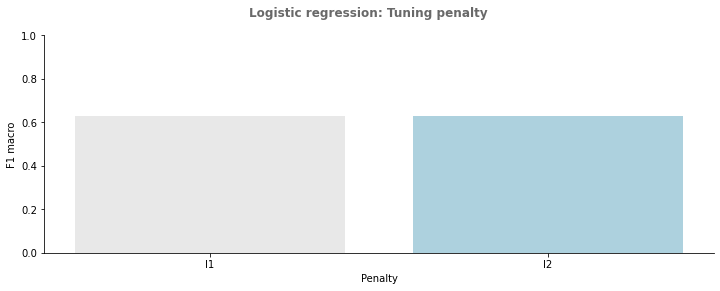

In [68]:
#Visualizing hyperparameter tuning
#Preparing data
y = gs.cv_results_["mean_test_score"][gs.cv_results_["mean_test_score"] > 0]

#Creating plot architecture
fig, ax = plt.subplots(figsize = (12, 4))
sns.despine(top = True)
fig.suptitle("Logistic regression: Tuning penalty",
             color = "#696969",
             weight = "bold",
             size = 12)

#Plotting
plt.bar(["l1", "l2"], y, color = "#E8E8E8")
plt.ylabel("F1 macro")
plt.ylim(0, 1)
plt.xlabel("Penalty")

#Setting parameters
ax.patches[1].set_facecolor("#add1de")

plt.show()

In [69]:
#Deriving best parameters for logistic regression
log_reg_params = [{"C": np.linspace(1, 100, 10)}]
gs = GridSearchCV(LogisticRegression(class_weight = {0: 1, 1: 8, 2: 5}, 
                                     penalty = "l2"), 
                  param_grid = log_reg_params,
                  cv = 2, 
                  scoring = "f1_macro")
gs.fit(X_train_lf_embed["clause_ABSA_spacy_vectors"].to_list(), y_train_lf["sentiment"])
best_params_C = gs.best_params_
best_params_C

{'C': 56.0}

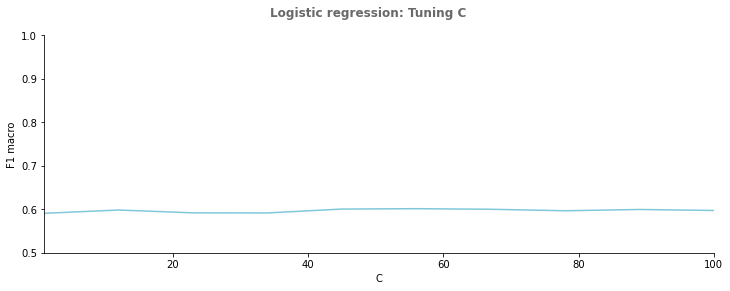

In [70]:
#Visualizing hyperparameter tuning
#Creating plot architecture
fig, ax = plt.subplots(figsize = (12, 4))
sns.despine(top = True)
fig.suptitle("Logistic regression: Tuning C",
             color = "#696969",
             weight = "bold",
             size = 12)

#Plotting
plt.plot(np.linspace(1, 100, 10), abs(gs.cv_results_["mean_test_score"]), color = "#7ec8d9")
plt.ylabel("F1 macro")
plt.ylim(0.5, 1)
plt.xlabel("C")
plt.xlim(1, 100)

plt.show()

In [71]:
#Deriving best parameters for logistic regression
log_reg_params = [{"solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]}]
gs = GridSearchCV(LogisticRegression(class_weight = {0: 1, 1: 8, 2: 5}, 
                                     penalty = "l2", 
                                     C = best_params_C["C"]), 
                  param_grid = log_reg_params,
                  cv = 2, 
                  scoring = "f1_macro")
gs.fit(X_train_lf_embed["clause_ABSA_spacy_vectors"].to_list(), y_train_lf["sentiment"])
best_params_solver = gs.best_params_
best_params_solver

{'solver': 'liblinear'}

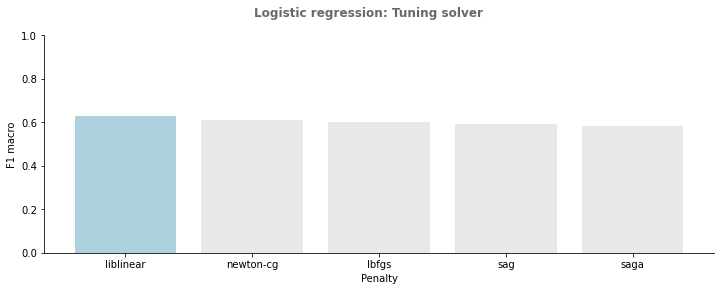

In [72]:
#Visualizing hyperparameter tuning
#Preparing data
gs_results = pd.DataFrame(data = {"f1_macro": abs(gs.cv_results_["mean_test_score"]), 
                                  "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]})
gs_results.sort_values("f1_macro", ascending = False, inplace = True)

#Creating plot architecture
fig, ax = plt.subplots(figsize = (12, 4))
sns.despine(top = True)
fig.suptitle("Logistic regression: Tuning solver",
             color = "#696969",
             weight = "bold",
             size = 12)

#Plotting
plt.bar(gs_results["solver"], gs_results["f1_macro"], color = "#E8E8E8")
plt.ylabel("F1 macro")
plt.ylim(0, 1)
plt.xlabel("Penalty")

#Setting parameters
ax.patches[0].set_facecolor("#add1de")

plt.show()

In [73]:
#Fitting logistic regression
log_reg = LogisticRegression(class_weight = {0: 1, 1: 8, 2: 5},
                             penalty = "l2",
                             C = 45, #best_params_C["C"], 
                             solver = "liblinear", #best_params_solver["solver"], 
                             random_state = 1)
log_reg.fit(X_train_lf_embed["clause_ABSA_spacy_vectors"].to_list(), y_train_lf["sentiment"])

LogisticRegression(C=45, class_weight={0: 1, 1: 8, 2: 5}, random_state=1,
                   solver='liblinear')

In [74]:
#Evaluating logistic regression
y_test_lf_pred = log_reg.predict(X_test_lf_embed["clause_ABSA_spacy_vectors"].to_list())
print(classification_report(y_test_lf["sentiment"], y_test_lf_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.90      0.91      1976
         1.0       0.45      0.52      0.49       124
         2.0       0.57      0.60      0.58       340

    accuracy                           0.84      2440
   macro avg       0.64      0.67      0.66      2440
weighted avg       0.84      0.84      0.84      2440



In [75]:
#Saving fitted model
os.chdir("..")
os.chdir("..")
os.chdir("Models/Articles/Snorkel/")
model_name = "log_reg_spacy_lf.pkl"
with open(model_name, "wb") as file:
    pickle.dump(log_reg, file)
os.chdir("..")
os.chdir("..")
os.chdir("..")
os.chdir("Notebooks/Articles")

In [76]:
#Setting labelling function with logistic regression
@labeling_function()
def log_reg_spacy_lf(string):
    #Opening models
    os.chdir("..")
    os.chdir("..")
    os.chdir("Models/Articles/Snorkel/")
    with open("log_reg_spacy_lf.pkl", "rb") as file:
        model = pickle.load(file)
    os.chdir("..")
    os.chdir("..")
    os.chdir("..")
    os.chdir("Notebooks/Articles")
        
    #Embed
    X = get_spacy_vectors(string["clause_ABSA"])
    
    #Prediction
    score = model.predict(X)

    return score[0]

#### Logistic regression - CountVectorizer

In [77]:
#Deriving best parameters for logistic regression
log_reg_params = [{"penalty": ["l1", "l2", "elasticnet", "none"]}]
gs = GridSearchCV(LogisticRegression(class_weight = {0: 1, 1: 8, 2: 5}, 
                                     solver = "liblinear"), 
                  param_grid = log_reg_params,
                  cv = 5, 
                  scoring = "f1_macro")
gs.fit(X_train_lf_vect, y_train_lf["sentiment"])
best_params_penalty = gs.best_params_
best_params_penalty

{'penalty': 'l2'}

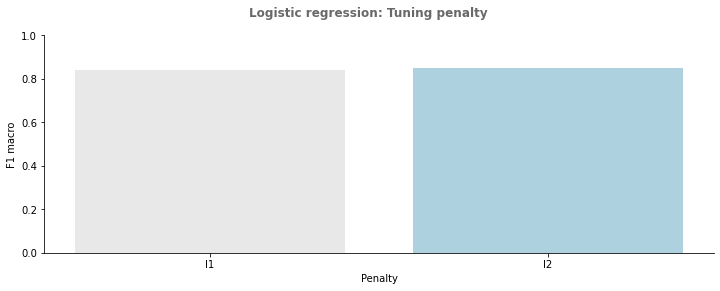

In [78]:
#Visualizing hyperparameter tuning
#Preparing data
y = gs.cv_results_["mean_test_score"][gs.cv_results_["mean_test_score"] > 0]

#Creating plot architecture
fig, ax = plt.subplots(figsize = (12, 4))
sns.despine(top = True)
fig.suptitle("Logistic regression: Tuning penalty",
             color = "#696969",
             weight = "bold",
             size = 12)

#Plotting
plt.bar(["l1", "l2"], y, color = "#E8E8E8")
plt.ylabel("F1 macro")
plt.ylim(0, 1)
plt.xlabel("Penalty")

#Setting parameters
ax.patches[1].set_facecolor("#add1de")

plt.show()

In [79]:
#Deriving best parameters for logistic regression
log_reg_params = [{"C": np.linspace(0.01, 10, 10)}]
gs = GridSearchCV(LogisticRegression(class_weight = {0: 1, 1: 8, 2: 5}, 
                                     penalty = "l2"), 
                  param_grid = log_reg_params,
                  cv = 5, 
                  scoring = "f1_macro")
gs.fit(X_train_lf_vect, y_train_lf["sentiment"])
best_params_C = gs.best_params_
best_params_C

{'C': 3.34}

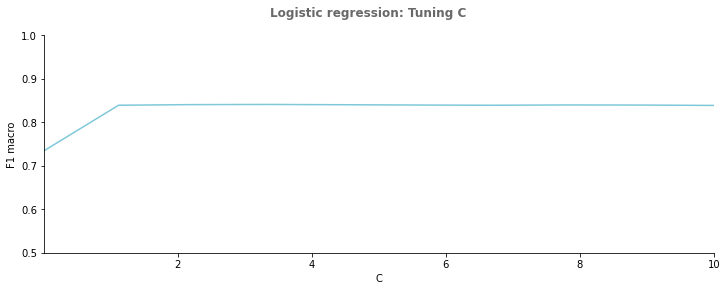

In [80]:
#Visualizing hyperparameter tuning
#Creating plot architecture
fig, ax = plt.subplots(figsize = (12, 4))
sns.despine(top = True)
fig.suptitle("Logistic regression: Tuning C",
             color = "#696969",
             weight = "bold",
             size = 12)

#Plotting
plt.plot(np.linspace(0.01, 10, 10), abs(gs.cv_results_["mean_test_score"]), color = "#7ec8d9")
plt.ylabel("F1 macro")
plt.ylim(0.5, 1)
plt.xlabel("C")
plt.xlim(0.01, 10)

plt.show()

In [81]:
#Deriving best parameters for logistic regression
log_reg_params = [{"solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]}]
gs = GridSearchCV(LogisticRegression(class_weight = {0: 1, 1: 8, 2: 5}, 
                                     penalty = "l2", 
                                     C = best_params_C["C"]), 
                  param_grid = log_reg_params,
                  cv = 5, 
                  scoring = "f1_macro")
gs.fit(X_train_lf_vect, y_train_lf["sentiment"])
best_params_solver = gs.best_params_
best_params_solver

{'solver': 'liblinear'}

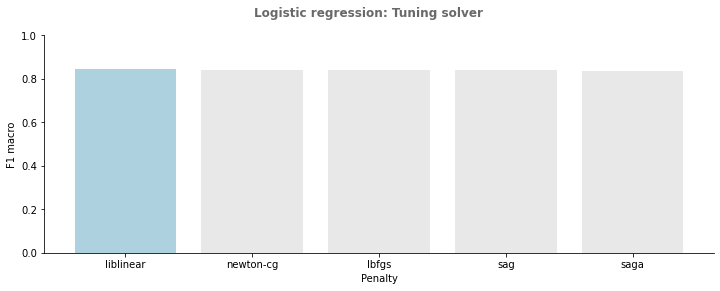

In [82]:
#Visualizing hyperparameter tuning
#Preparing data
gs_results = pd.DataFrame(data = {"f1_macro": abs(gs.cv_results_["mean_test_score"]), 
                                  "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]})
gs_results.sort_values("f1_macro", ascending = False, inplace = True)

#Creating plot architecture
fig, ax = plt.subplots(figsize = (12, 4))
sns.despine(top = True)
fig.suptitle("Logistic regression: Tuning solver",
             color = "#696969",
             weight = "bold",
             size = 12)

#Plotting
plt.bar(gs_results["solver"], gs_results["f1_macro"], color = "#E8E8E8")
plt.ylabel("F1 macro")
plt.ylim(0, 1)
plt.xlabel("Penalty")

#Setting parameters
ax.patches[0].set_facecolor("#add1de")

plt.show()

In [83]:
#Fitting logistic regression
log_reg = LogisticRegression(class_weight = {0: 1, 1: 8, 2: 5},
                             penalty = "l2",
                             C = best_params_C["C"], 
                             solver = best_params_solver["solver"], 
                             random_state = 1)
log_reg.fit(X_train_lf_vect, y_train_lf["sentiment"])

LogisticRegression(C=3.34, class_weight={0: 1, 1: 8, 2: 5}, random_state=1,
                   solver='liblinear')

In [84]:
#Evaluating logistic regression
y_test_lf_pred = log_reg.predict(X_test_lf_vect)
print(classification_report(y_test_lf["sentiment"], y_test_lf_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96      1976
         1.0       0.88      0.70      0.78       124
         2.0       0.91      0.77      0.83       340

    accuracy                           0.94      2440
   macro avg       0.91      0.82      0.86      2440
weighted avg       0.94      0.94      0.94      2440



In [85]:
#Saving fitted model
os.chdir("..")
os.chdir("..")
os.chdir("Models/Articles/Snorkel/")
model_name = "log_reg_cv_lf.pkl"
with open(model_name, "wb") as file:
    pickle.dump(log_reg, file)
os.chdir("..")
os.chdir("..")
os.chdir("..")
os.chdir("Notebooks/Articles")

In [86]:
#Setting labelling function with logistic regression
@labeling_function()
def log_reg_cv_lf(string):
    #Opening models
    os.chdir("..")
    os.chdir("..")
    os.chdir("Models/Articles/Snorkel/")
    with open("cv_lf.pkl", "rb") as file:
        cv = pickle.load(file)
    with open("log_reg_cv_lf.pkl", "rb") as file:
        model = pickle.load(file)
    os.chdir("..")
    os.chdir("..")
    os.chdir("..")
    os.chdir("Notebooks/Articles")
        
    #CountVectorizer transform
    X = cv.transform(pd.Series(string["clause_ABSA"]))
    
    #Prediction
    score = model.predict(X)

    return score[0]

#### SVM - Spacy vectors

In [87]:
#Deriving best parameters for SVM
svm_params = [{"kernel": ["linear", "poly", "rbf", "sigmoid"]}] 
gs = GridSearchCV(SVC(class_weight = {0: 1, 1: 8, 2: 5}), 
                  param_grid = svm_params,
                  cv = 2, 
                  scoring = "f1_macro")
gs.fit(X_train_lf_embed["clause_ABSA_spacy_vectors"].to_list(), y_train_lf["sentiment"])
best_params_kernel = gs.best_params_
best_params_kernel

{'kernel': 'poly'}

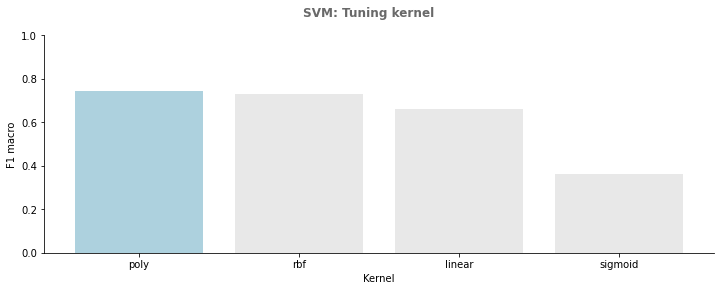

In [88]:
#Visualizing hyperparameter tuning
#Preparing data
gs_results = pd.DataFrame(data = {"f1_macro": abs(gs.cv_results_["mean_test_score"]), 
                                  "kernel": ["linear", "poly", "rbf", "sigmoid"]})
gs_results.sort_values("f1_macro", ascending = False, inplace = True)

#Creating plot architecture
fig, ax = plt.subplots(figsize = (12, 4))
sns.despine(top = True)
fig.suptitle("SVM: Tuning kernel",
             color = "#696969",
             weight = "bold",
             size = 12)

#Plotting
plt.bar(gs_results["kernel"], gs_results["f1_macro"], color = "#E8E8E8")
plt.ylabel("F1 macro")
plt.ylim(0, 1)
plt.xlabel("Kernel")

#Setting parameters
ax.patches[0].set_facecolor("#add1de")

plt.show()

In [89]:
#Deriving best parameters for SVM
svm_params = [{"gamma": np.linspace(0.001, 1, 10)}] 
gs = GridSearchCV(SVC(class_weight = {0: 1, 1: 8, 2: 5},
                      kernel = best_params_kernel["kernel"]), 
                  param_grid = svm_params,
                  cv = 2, 
                  scoring = "f1_macro")
gs.fit(X_train_lf_embed["clause_ABSA_spacy_vectors"].to_list(), y_train_lf["sentiment"])
best_params_gamma = gs.best_params_
best_params_gamma

{'gamma': 0.112}

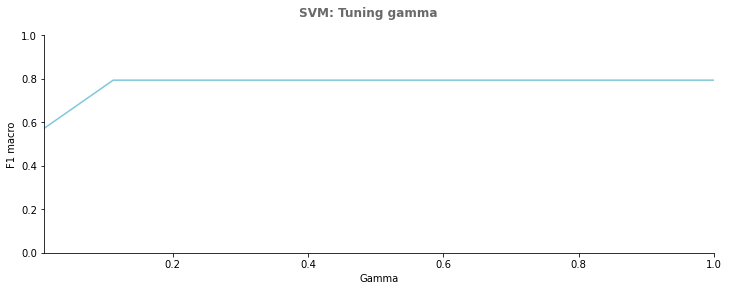

In [90]:
#Visualizing hyperparameter tuning
#Creating plot architecture
fig, ax = plt.subplots(figsize = (12, 4))
sns.despine(top = True)
fig.suptitle("SVM: Tuning gamma",
             color = "#696969",
             weight = "bold",
             size = 12)

#Plotting
plt.plot(np.linspace(0.001, 1, 10), abs(gs.cv_results_["mean_test_score"]), color = "#7ec8d9")
plt.ylabel("F1 macro")
plt.ylim(0, 1)
plt.xlabel("Gamma")
plt.xlim(0.01, 1)

plt.show()

In [91]:
#Deriving best parameters for SVM
svm_params = [{"C": np.linspace(0.001, 1, 10)}] 
gs = GridSearchCV(SVC(class_weight = {0: 1, 1: 8, 2: 5},
                      kernel = best_params_kernel["kernel"], 
                      gamma = best_params_gamma["gamma"]), 
                  param_grid = svm_params,
                  cv = 2, 
                  scoring = "f1_macro")
gs.fit(X_train_lf_embed["clause_ABSA_spacy_vectors"].to_list(), y_train_lf["sentiment"])
best_params_C = gs.best_params_
best_params_C

{'C': 0.001}

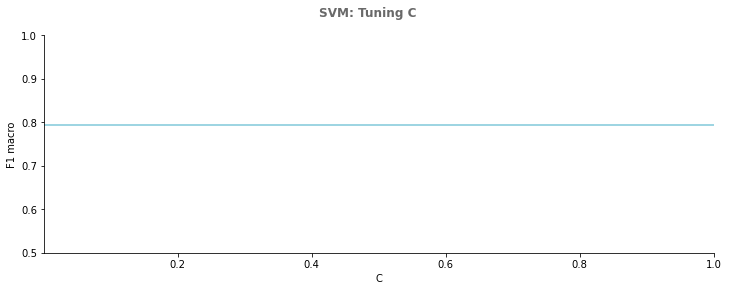

In [92]:
#Visualizing hyperparameter tuning
#Creating plot architecture
fig, ax = plt.subplots(figsize = (12, 4))
sns.despine(top = True)
fig.suptitle("SVM: Tuning C",
             color = "#696969",
             weight = "bold",
             size = 12)

#Plotting
plt.plot(np.linspace(0.001, 1, 10), abs(gs.cv_results_["mean_test_score"]), color = "#7ec8d9")
plt.ylabel("F1 macro")
plt.ylim(0.5, 1)
plt.xlabel("C")
plt.xlim(0.001, 1)

plt.show()

In [93]:
#Fitting SVM
svm = SVC(class_weight = {0: 1, 1: 8, 2: 5},
          kernel = best_params_kernel["kernel"], 
          gamma = best_params_gamma["gamma"],
          C = best_params_C["C"],
          random_state = 1)
svm.fit(X_train_lf_embed["clause_ABSA_spacy_vectors"].to_list(), y_train_lf["sentiment"])

SVC(C=0.001, class_weight={0: 1, 1: 8, 2: 5}, gamma=0.112, kernel='poly',
    random_state=1)

In [94]:
#Evaluating SVM
y_test_lf_pred = svm.predict(X_test_lf_embed["clause_ABSA_spacy_vectors"].to_list())
print(classification_report(y_test_lf["sentiment"], y_test_lf_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96      1976
         1.0       0.73      0.70      0.72       124
         2.0       0.87      0.79      0.83       340

    accuracy                           0.93      2440
   macro avg       0.85      0.82      0.83      2440
weighted avg       0.93      0.93      0.93      2440



In [95]:
#Saving fitted model
os.chdir("..")
os.chdir("..")
os.chdir("Models/Articles/Snorkel/")
model_name = "svm_spacy_lf.pkl"
with open(model_name, "wb") as file:
    pickle.dump(svm, file)
os.chdir("..")
os.chdir("..")
os.chdir("..")
os.chdir("Notebooks/Articles")

In [96]:
#Setting labelling function with SVM
@labeling_function()
def svm_spacy_lf(string):
    #Opening models
    os.chdir("..")
    os.chdir("..")
    os.chdir("Models/Articles/Snorkel/")
    with open("svm_spacy_lf.pkl", "rb") as file:
        model = pickle.load(file)
    os.chdir("..")
    os.chdir("..")
    os.chdir("..")
    os.chdir("Notebooks/Articles")
        
    #Embed
    X = get_spacy_vectors(string["clause_ABSA"])
    
    #Prediction
    score = model.predict(X)

    return score[0]

#### SVM - CountVectorizer

In [97]:
#Deriving best parameters for SVM
svm_params = [{"kernel": ["linear", "poly", "rbf", "sigmoid"]}] 
gs = GridSearchCV(SVC(class_weight = {0: 1, 1: 8, 2: 5}), 
                  param_grid = svm_params,
                  cv = 5, 
                  scoring = "f1_macro")
gs.fit(X_train_lf_vect, y_train_lf["sentiment"])
best_params_kernel = gs.best_params_
best_params_kernel

{'kernel': 'rbf'}

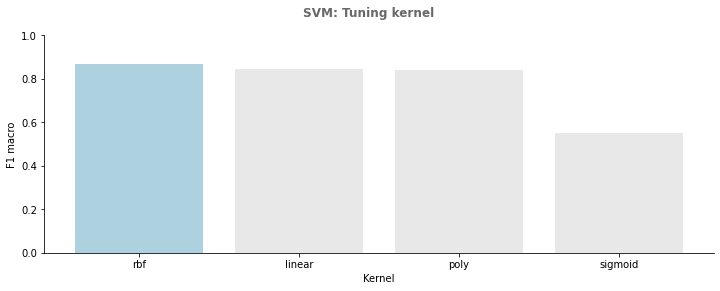

In [98]:
#Visualizing hyperparameter tuning
#Preparing data
gs_results = pd.DataFrame(data = {"f1_macro": abs(gs.cv_results_["mean_test_score"]), 
                                  "kernel": ["linear", "poly", "rbf", "sigmoid"]})
gs_results.sort_values("f1_macro", ascending = False, inplace = True)

#Creating plot architecture
fig, ax = plt.subplots(figsize = (12, 4))
sns.despine(top = True)
fig.suptitle("SVM: Tuning kernel",
             color = "#696969",
             weight = "bold",
             size = 12)

#Plotting
plt.bar(gs_results["kernel"], gs_results["f1_macro"], color = "#E8E8E8")
plt.ylabel("F1 macro")
plt.ylim(0, 1)
plt.xlabel("Kernel")

#Setting parameters
ax.patches[0].set_facecolor("#add1de")

plt.show()

In [99]:
#Deriving best parameters for SVM
svm_params = [{"gamma": np.linspace(0.001, 1, 10)}] 
gs = GridSearchCV(SVC(class_weight = {0: 1, 1: 8, 2: 5},
                      kernel = best_params_kernel["kernel"]), 
                  param_grid = svm_params,
                  cv = 5, 
                  scoring = "f1_macro")
gs.fit(X_train_lf_vect, y_train_lf["sentiment"])
best_params_gamma = gs.best_params_
best_params_gamma

{'gamma': 0.112}

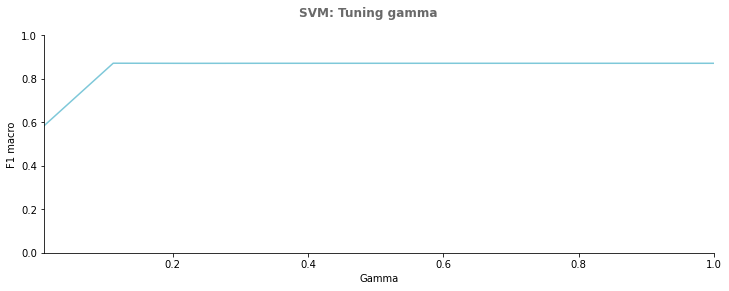

In [100]:
#Visualizing hyperparameter tuning
#Creating plot architecture
fig, ax = plt.subplots(figsize = (12, 4))
sns.despine(top = True)
fig.suptitle("SVM: Tuning gamma",
             color = "#696969",
             weight = "bold",
             size = 12)

#Plotting
plt.plot(np.linspace(0.001, 1, 10), abs(gs.cv_results_["mean_test_score"]), color = "#7ec8d9")
plt.ylabel("F1 macro")
plt.ylim(0, 1)
plt.xlabel("Gamma")
plt.xlim(0.01, 1)

plt.show()

In [101]:
#Deriving best parameters for SVM
svm_params = [{"C": np.linspace(0.1, 1, 10)}] 
gs = GridSearchCV(SVC(class_weight = {0: 1, 1: 8, 2: 5},
                      kernel = best_params_kernel["kernel"], 
                      gamma = best_params_gamma["gamma"]), 
                  param_grid = svm_params,
                  cv = 5, 
                  scoring = "f1_macro")
gs.fit(X_train_lf_vect, y_train_lf["sentiment"])
best_params_C = gs.best_params_
best_params_C

{'C': 0.8}

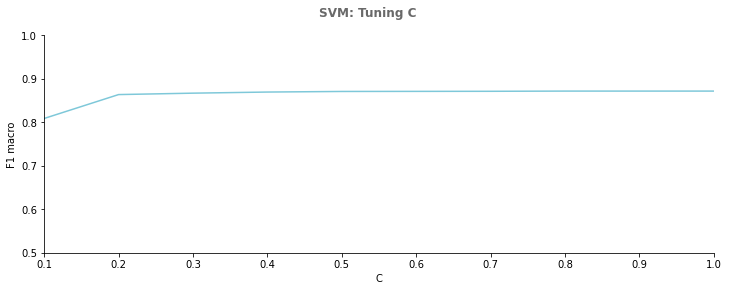

In [102]:
#Visualizing hyperparameter tuning
#Creating plot architecture
fig, ax = plt.subplots(figsize = (12, 4))
sns.despine(top = True)
fig.suptitle("SVM: Tuning C",
             color = "#696969",
             weight = "bold",
             size = 12)

#Plotting
plt.plot(np.linspace(0.1, 1, 10), abs(gs.cv_results_["mean_test_score"]), color = "#7ec8d9")
plt.ylabel("F1 macro")
plt.ylim(0.5, 1)
plt.xlabel("C")
plt.xlim(0.1, 1)

plt.show()

In [103]:
#Fitting SVM
svm = SVC(class_weight = {0: 1, 1: 8, 2: 5},
          kernel = best_params_kernel["kernel"], 
          gamma = best_params_gamma["gamma"],
          C = best_params_C["C"],
          random_state = 1)
svm.fit(X_train_lf_vect, y_train_lf["sentiment"])

SVC(C=0.8, class_weight={0: 1, 1: 8, 2: 5}, gamma=0.112, random_state=1)

In [104]:
#Evaluating SVM
y_test_lf_pred = svm.predict(X_test_lf_vect)
print(classification_report(y_test_lf["sentiment"], y_test_lf_pred))

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97      1976
         1.0       0.98      0.69      0.81       124
         2.0       1.00      0.74      0.85       340

    accuracy                           0.95      2440
   macro avg       0.97      0.81      0.87      2440
weighted avg       0.95      0.95      0.94      2440



In [105]:
#Saving fitted model
os.chdir("..")
os.chdir("..")
os.chdir("Models/Articles/Snorkel/")
model_name = "svm_cv_lf.pkl"
with open(model_name, "wb") as file:
    pickle.dump(svm, file)
os.chdir("..")
os.chdir("..")
os.chdir("..")
os.chdir("Notebooks/Articles")

In [106]:
#Setting labelling function with SVM
@labeling_function()
def svm_cv_lf(string):
    #Opening models
    os.chdir("..")
    os.chdir("..")
    os.chdir("Models/Articles/Snorkel/")
    with open("cv_lf.pkl", "rb") as file:
        cv = pickle.load(file)
    with open("svm_cv_lf.pkl", "rb") as file:
        model = pickle.load(file)
    os.chdir("..")
    os.chdir("..")
    os.chdir("..")
    os.chdir("Notebooks/Articles")
        
    #CountVectorizer transform
    X = cv.transform(pd.Series(string["clause_ABSA"]))
    
    #Prediction
    score = model.predict(X)

    return score[0]

#### XGBoost - Spacy vectors

In [107]:
#Deriving best parameters for XGBoost
xgbr_params = [{"booster": ["gbtree", "gblinear", "dart"]}]
gs = GridSearchCV(xg.XGBClassifier(), 
                  param_grid = xgbr_params,
                  cv = 2, 
                  scoring = "f1_macro")
gs.fit(X_train_lf_embed["clause_ABSA_spacy_vectors"].to_list(), y_train_lf["sentiment"])
best_params_booster = gs.best_params_
best_params_booster

{'booster': 'gbtree'}

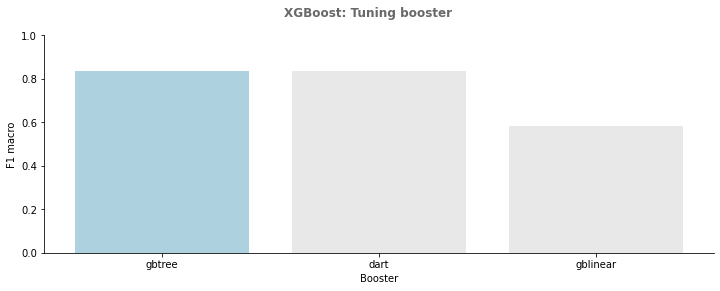

In [108]:
#Visualizing hyperparameter tuning
#Preparing data
gs_results = pd.DataFrame(data = {"f1_macro": abs(gs.cv_results_["mean_test_score"]), 
                                  "booster": ["gbtree", "gblinear", "dart"]})
gs_results.sort_values("f1_macro", ascending = False, inplace = True)

#Creating plot architecture
fig, ax = plt.subplots(figsize = (12, 4))
sns.despine(top = True)
fig.suptitle("XGBoost: Tuning booster",
             color = "#696969",
             weight = "bold",
             size = 12)

#Plotting
plt.bar(gs_results["booster"], gs_results["f1_macro"], color = "#E8E8E8")
plt.ylabel("F1 macro")
plt.ylim(0, 1)
plt.xlabel("Booster")

#Setting parameters
ax.patches[0].set_facecolor("#add1de")

plt.show()

In [109]:
#Deriving best parameters for XGBoost
xgbr_params = [{"learning_rate": np.linspace(0.1, 1, num = 10)}]
gs = GridSearchCV(xg.XGBClassifier(booster = "gbtree"), 
                  param_grid = xgbr_params,
                  cv = 2, 
                  scoring = "f1_macro")
gs.fit(X_train_lf_embed["clause_ABSA_spacy_vectors"].to_list(), y_train_lf["sentiment"])
best_params_learning_rate = gs.best_params_
best_params_learning_rate

{'learning_rate': 0.30000000000000004}

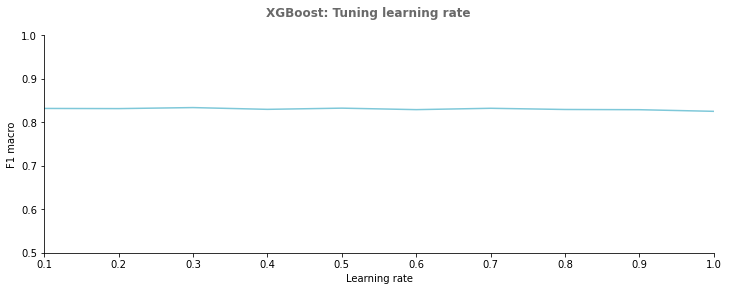

In [110]:
#Visualizing hyperparameter tuning
#Creating plot architecture
fig, ax = plt.subplots(figsize = (12, 4))
sns.despine(top = True)
fig.suptitle("XGBoost: Tuning learning rate",
             color = "#696969",
             weight = "bold",
             size = 12)

#Plotting
plt.plot(np.linspace(0.1, 1, num = 10), abs(gs.cv_results_["mean_test_score"]), color = "#7ec8d9")
plt.ylabel("F1 macro")
plt.ylim(0.5, 1)
plt.xlabel("Learning rate")
plt.xlim(0.1, 1)

plt.show()

In [111]:
#Deriving best parameters for XGBoost
xgbr_params = [{"max_depth": [4,5,6,7,8,9,10]}]
gs = GridSearchCV(xg.XGBClassifier(booster = "gbtree",
                                   #best_params_booster["booster"], 
                                   learning_rate = best_params_learning_rate["learning_rate"]), 
                  param_grid = xgbr_params,
                  cv = 2, 
                  scoring = "f1_macro")
gs.fit(X_train_lf_embed["clause_ABSA_spacy_vectors"].to_list(), y_train_lf["sentiment"])
best_params_max_depth = gs.best_params_
best_params_max_depth

{'max_depth': 4}

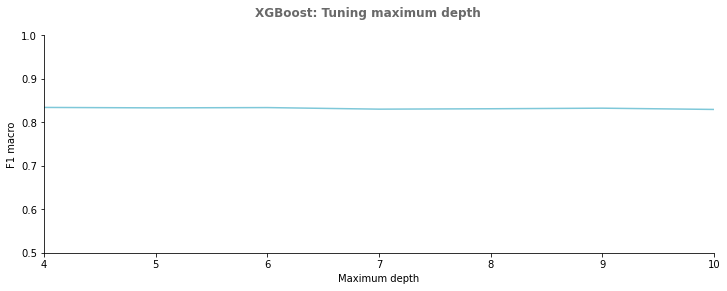

In [112]:
#Visualizing hyperparameter tuning
#Creating plot architecture
fig, ax = plt.subplots(figsize = (12, 4))
sns.despine(top = True)
fig.suptitle("XGBoost: Tuning maximum depth",
             color = "#696969",
             weight = "bold",
             size = 12)

#Plotting
plt.plot([4,5,6,7,8,9,10], abs(gs.cv_results_["mean_test_score"]), color = "#7ec8d9")
plt.ylabel("F1 macro")
plt.ylim(0.5, 1)
plt.xlabel("Maximum depth")
plt.xlim(4, 10)

plt.show()

In [113]:
#Deriving best parameters for XGBoost
xgbr_params = [{"subsample": np.linspace(0.5, 1, num = 5)}]
gs = GridSearchCV(xg.XGBClassifier(booster = "gbtree",
                                   #best_params_booster["booster"],
                                   learning_rate = best_params_learning_rate["learning_rate"],
                                   max_depth = best_params_max_depth["max_depth"]), 
                  param_grid = xgbr_params,
                  cv = 2, 
                  scoring = "f1_macro")
gs.fit(X_train_lf_embed["clause_ABSA_spacy_vectors"].to_list(), y_train_lf["sentiment"])
best_params_subsample = gs.best_params_
best_params_subsample

{'subsample': 0.75}

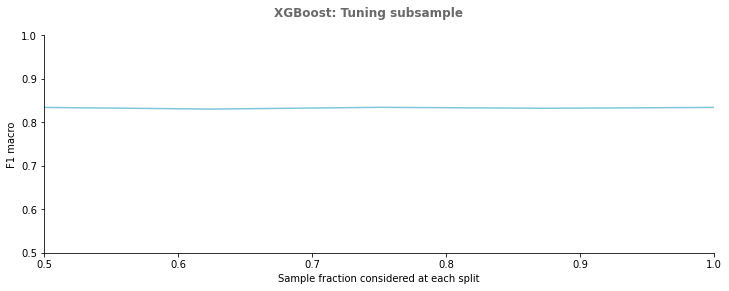

In [114]:
#Visualizing hyperparameter tuning
#Creating plot architecture
fig, ax = plt.subplots(figsize = (12, 4))
sns.despine(top = True)
fig.suptitle("XGBoost: Tuning subsample",
             color = "#696969",
             weight = "bold",
             size = 12)

#Plotting
plt.plot(np.linspace(0.5, 1, num = 5), abs(gs.cv_results_["mean_test_score"]), color = "#7ec8d9")
plt.ylabel("F1 macro")
plt.ylim(0.5, 1)
plt.xlabel("Sample fraction considered at each split")
plt.xlim(0.5, 1.0)

plt.show()

In [115]:
#Deriving best parameters for XGBoost
xgbr_params = [{"colsample_bytree": np.linspace(0.5, 1, num = 5)}]
gs = GridSearchCV(xg.XGBClassifier(booster = "gbtree",
                                   #best_params_booster["booster"],
                                   learning_rate = best_params_learning_rate["learning_rate"],
                                   max_depth = best_params_max_depth["max_depth"],
                                   subsample = best_params_subsample["subsample"]), 
                  param_grid = xgbr_params,
                  cv = 2, 
                  scoring = "f1_macro")
gs.fit(X_train_lf_embed["clause_ABSA_spacy_vectors"].to_list(), y_train_lf["sentiment"])
best_params_colsample = gs.best_params_
best_params_colsample

{'colsample_bytree': 1.0}

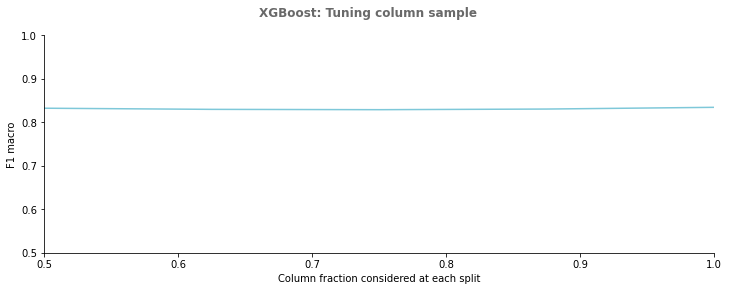

In [116]:
#Visualizing hyperparameter tuning
#Creating plot architecture
fig, ax = plt.subplots(figsize = (12, 4))
sns.despine(top = True)
fig.suptitle("XGBoost: Tuning column sample",
             color = "#696969",
             weight = "bold",
             size = 12)

#Plotting
plt.plot(np.linspace(0.5, 1, num = 5), abs(gs.cv_results_["mean_test_score"]), color = "#7ec8d9")
plt.ylabel("F1 macro")
plt.ylim(0.5, 1)
plt.xlabel("Column fraction considered at each split")
plt.xlim(0.5, 1)

plt.show()

In [117]:
#Deriving hyperparameters for XGBoost
rndf_params = [{"n_estimators": [x for x in range(50, 150, 3)]}]
gs = GridSearchCV(xg.XGBClassifier(booster = "gbtree",
                                   #best_params_booster["booster"],
                                   learning_rate = best_params_learning_rate["learning_rate"],
                                   max_depth = best_params_max_depth["max_depth"],
                                   subsample = best_params_subsample["subsample"], 
                                   colsample_bytree = best_params_colsample["colsample_bytree"]), 
                  param_grid = rndf_params,
                  cv = 2, 
                  scoring = "f1_macro")
gs.fit(X_train_lf_embed["clause_ABSA_spacy_vectors"].to_list(), y_train_lf["sentiment"])
best_params_estimators = gs.best_params_
best_params_estimators

{'n_estimators': 107}

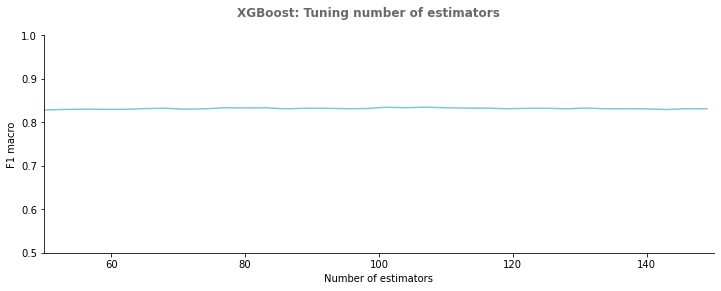

In [118]:
#Visualizing hyperparameter tuning
#Creating plot architecture
fig, ax = plt.subplots(figsize = (12, 4))
sns.despine(top = True)
fig.suptitle("XGBoost: Tuning number of estimators",
             color = "#696969",
             weight = "bold",
             size = 12)

#Plotting
plt.plot([x for x in range(50, 150, 3)], abs(gs.cv_results_["mean_test_score"]), color = "#7ec8d9")
plt.ylabel("F1 macro")
plt.ylim(0.5, 1)
plt.xlabel("Number of estimators")
plt.xlim(50, 150)

plt.show()

In [119]:
#Deriving hyperparameters for XGBoost
rndf_params = [{"gamma": np.linspace(0.005, 0.05, 10)}]
gs = GridSearchCV(xg.XGBClassifier(booster = "gbtree",
                                   #best_params_booster["booster"],
                                   learning_rate = best_params_learning_rate["learning_rate"],
                                   max_depth = best_params_max_depth["max_depth"],
                                   subsample = best_params_subsample["subsample"], 
                                   colsample_bytree = best_params_colsample["colsample_bytree"], 
                                   n_estimators = best_params_estimators["n_estimators"]), 
                  param_grid = rndf_params,
                  cv = 2, 
                  scoring = "f1_macro")
gs.fit(X_train_lf_embed["clause_ABSA_spacy_vectors"].to_list(), y_train_lf["sentiment"])
best_params_gamma = gs.best_params_
best_params_gamma

{'gamma': 0.030000000000000006}

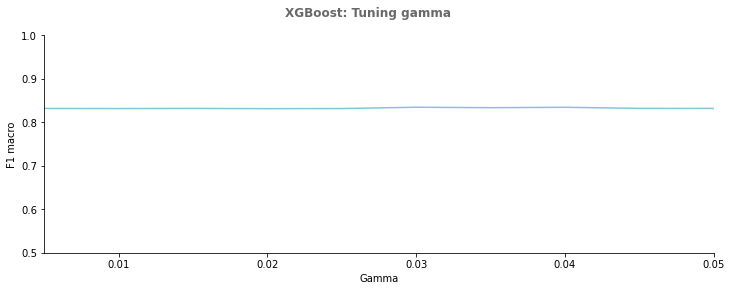

In [120]:
#Visualizing hyperparameter tuning
#Creating plot architecture
fig, ax = plt.subplots(figsize = (12, 4))
sns.despine(top = True)
fig.suptitle("XGBoost: Tuning gamma",
             color = "#696969",
             weight = "bold",
             size = 12)

#Plotting
plt.plot(np.linspace(0.005, 0.05, 10), abs(gs.cv_results_["mean_test_score"]), color = "#7ec8d9")
plt.ylabel("F1 macro")
plt.ylim(0.5, 1)
plt.xlabel("Gamma")
plt.xlim(0.005, 0.05)

plt.show()

In [121]:
#Fitting XGBoost
xgbr = xg.XGBClassifier(objective = "binary:f1_macro", 
                        booster = "gbtree",
                        #best_params_booster["booster"],
                        learning_rate = best_params_learning_rate["learning_rate"],
                        max_depth = int(best_params_max_depth["max_depth"]),
                        subsample = best_params_subsample["subsample"],
                        colsample_bytree = best_params_colsample["colsample_bytree"], 
                        n_estimators = best_params_estimators["n_estimators"],
                        gamma = best_params_gamma["gamma"],
                        random_state = 1)
xgbr.fit(X_train_lf_embed["clause_ABSA_spacy_vectors"].to_list(), y_train_lf["sentiment"])

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.030000000000000006, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.30000000000000004,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=4,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=107, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=1, reg_alpha=0, ...)

In [122]:
#Evaluating XGBoost
y_test_lf_pred = xgbr.predict(X_test_lf_embed["clause_ABSA_spacy_vectors"].to_list())
print(classification_report(y_test_lf["sentiment"], y_test_lf_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97      1976
         1.0       0.94      0.67      0.78       124
         2.0       0.97      0.75      0.85       340

    accuracy                           0.94      2440
   macro avg       0.95      0.80      0.86      2440
weighted avg       0.94      0.94      0.94      2440



In [123]:
#Saving fitted model
os.chdir("..")
os.chdir("..")
os.chdir("Models/Articles/Snorkel/")
model_name = "xgbr_spacy_lf.pkl"
with open(model_name, "wb") as file:
    pickle.dump(xgbr, file)
os.chdir("..")
os.chdir("..")
os.chdir("..")
os.chdir("Notebooks/Articles")

In [124]:
#Setting labelling function with XGBR
@labeling_function()
def xgbr_spacy_lf(string):
    #Opening models
    os.chdir("..")
    os.chdir("..")
    os.chdir("Models/Articles/Snorkel/")
    with open("xgbr_spacy_lf.pkl", "rb") as file:
        model = pickle.load(file)
    os.chdir("..")
    os.chdir("..")
    os.chdir("..")
    os.chdir("Notebooks/Articles")
        
    #Embed
    X = get_spacy_vectors(string["clause_ABSA"])
    
    #Prediction
    score = model.predict(X)

    return score[0]

#### XGBoost - CountVectorizer

In [125]:
#Deriving best parameters for XGBoost
xgbr_params = [{"booster": ["gbtree", "gblinear", "dart"]}]
gs = GridSearchCV(xg.XGBClassifier(), 
                  param_grid = xgbr_params,
                  cv = 5, 
                  scoring = "f1_macro")
gs.fit(X_train_lf_vect, y_train_lf["sentiment"])
best_params_booster = gs.best_params_
best_params_booster

{'booster': 'gblinear'}

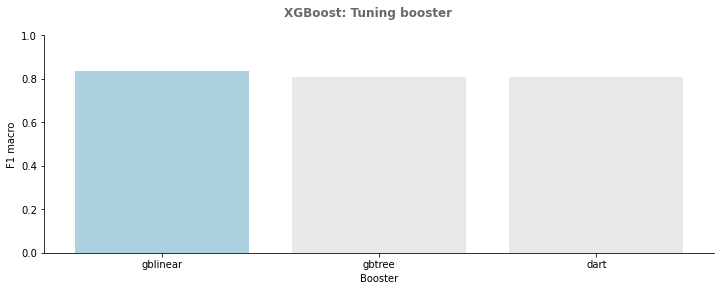

In [126]:
#Visualizing hyperparameter tuning
#Preparing data
gs_results = pd.DataFrame(data = {"f1_macro": abs(gs.cv_results_["mean_test_score"]), 
                                  "booster": ["gbtree", "gblinear", "dart"]})
gs_results.sort_values("f1_macro", ascending = False, inplace = True)

#Creating plot architecture
fig, ax = plt.subplots(figsize = (12, 4))
sns.despine(top = True)
fig.suptitle("XGBoost: Tuning booster",
             color = "#696969",
             weight = "bold",
             size = 12)

#Plotting
plt.bar(gs_results["booster"], gs_results["f1_macro"], color = "#E8E8E8")
plt.ylabel("F1 macro")
plt.ylim(0, 1)
plt.xlabel("Booster")

#Setting parameters
ax.patches[0].set_facecolor("#add1de")

plt.show()

In [127]:
#Deriving best parameters for XGBoost
xgbr_params = [{"learning_rate": np.linspace(0.1, 10, 10)}]
gs = GridSearchCV(xg.XGBClassifier(booster = "gbtree"), 
                  param_grid = xgbr_params,
                  cv = 5, 
                  scoring = "f1_macro")
gs.fit(X_train_lf_vect, y_train_lf["sentiment"])
best_params_learning_rate = gs.best_params_
best_params_learning_rate

{'learning_rate': 1.2000000000000002}

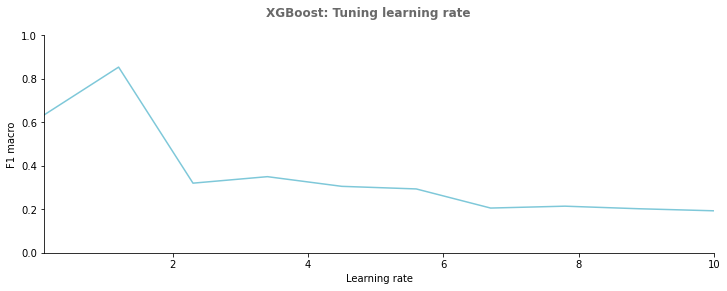

In [128]:
# Visualizing hyperparameter tuning
#Creating plot architecture
fig, ax = plt.subplots(figsize = (12, 4))
sns.despine(top = True)
fig.suptitle("XGBoost: Tuning learning rate",
             color = "#696969",
             weight = "bold",
             size = 12)

#Plotting
plt.plot(np.linspace(0.1, 10, 10), abs(gs.cv_results_["mean_test_score"]), color = "#7ec8d9")
plt.ylabel("F1 macro")
plt.ylim(0, 1)
plt.xlabel("Learning rate")
plt.xlim(0.1, 10)

plt.show()

In [129]:
#Deriving best parameters for XGBoost
xgbr_params = [{"max_depth": [8,10,12,14,16,18]}]
gs = GridSearchCV(xg.XGBClassifier(booster = "gbtree",
                                   #best_params_booster["booster"], 
                                   learning_rate = best_params_learning_rate["learning_rate"]), 
                  param_grid = xgbr_params,
                  cv = 5, 
                  scoring = "f1_macro")
gs.fit(X_train_lf_vect, y_train_lf["sentiment"])
best_params_max_depth = gs.best_params_
best_params_max_depth

{'max_depth': 18}

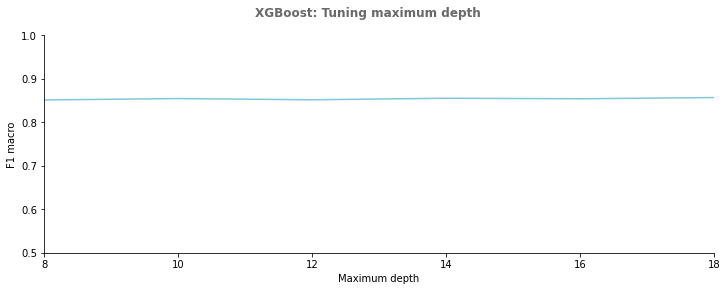

In [130]:
#Visualizing hyperparameter tuning
#Creating plot architecture
fig, ax = plt.subplots(figsize = (12, 4))
sns.despine(top = True)
fig.suptitle("XGBoost: Tuning maximum depth",
             color = "#696969",
             weight = "bold",
             size = 12)

#Plotting
plt.plot([8,10,12,14,16,18], abs(gs.cv_results_["mean_test_score"]), color = "#7ec8d9")
plt.ylabel("F1 macro")
plt.ylim(0.5, 1)
plt.xlabel("Maximum depth")
plt.xlim(8,18)

plt.show()

In [131]:
#Deriving best parameters for XGBoost
xgbr_params = [{"subsample": np.linspace(0.5, 1, num = 5)}]
gs = GridSearchCV(xg.XGBClassifier(booster = "gbtree",
                                   #best_params_booster["booster"],
                                   learning_rate = best_params_learning_rate["learning_rate"],
                                   max_depth = best_params_max_depth["max_depth"]), 
                  param_grid = xgbr_params,
                  cv = 5, 
                  scoring = "f1_macro")
gs.fit(X_train_lf_vect, y_train_lf["sentiment"])
best_params_subsample = gs.best_params_
best_params_subsample

{'subsample': 1.0}

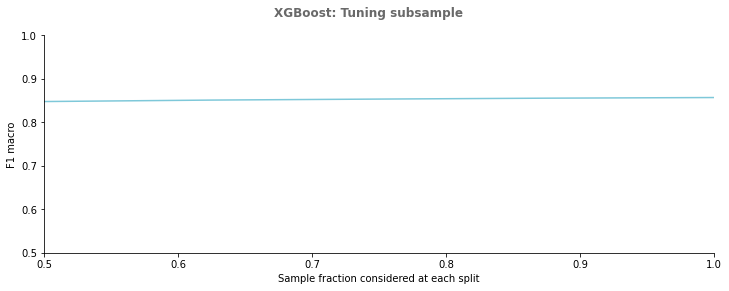

In [132]:
#Visualizing hyperparameter tuning
#Creating plot architecture
fig, ax = plt.subplots(figsize = (12, 4))
sns.despine(top = True)
fig.suptitle("XGBoost: Tuning subsample",
             color = "#696969",
             weight = "bold",
             size = 12)

#Plotting
plt.plot(np.linspace(0.5, 1, num = 5), abs(gs.cv_results_["mean_test_score"]), color = "#7ec8d9")
plt.ylabel("F1 macro")
plt.ylim(0.5, 1)
plt.xlabel("Sample fraction considered at each split")
plt.xlim(0.5, 1.0)

plt.show()

In [133]:
#Deriving best parameters for XGBoost
xgbr_params = [{"colsample_bytree": np.linspace(0.5, 1, num = 5)}]
gs = GridSearchCV(xg.XGBClassifier(booster = "gbtree",
                                   #best_params_booster["booster"],
                                   learning_rate = best_params_learning_rate["learning_rate"],
                                   max_depth = best_params_max_depth["max_depth"],
                                   subsample = best_params_subsample["subsample"]), 
                  param_grid = xgbr_params,
                  cv = 5, 
                  scoring = "f1_macro")
gs.fit(X_train_lf_vect, y_train_lf["sentiment"])
best_params_colsample = gs.best_params_
best_params_colsample

{'colsample_bytree': 0.625}

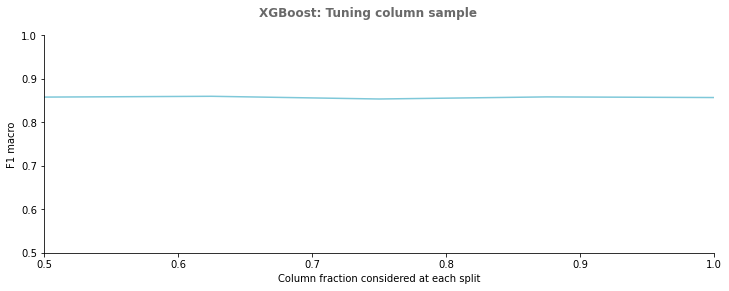

In [134]:
#Visualizing hyperparameter tuning
#Creating plot architecture
fig, ax = plt.subplots(figsize = (12, 4))
sns.despine(top = True)
fig.suptitle("XGBoost: Tuning column sample",
             color = "#696969",
             weight = "bold",
             size = 12)

#Plotting
plt.plot(np.linspace(0.5, 1, num = 5), abs(gs.cv_results_["mean_test_score"]), color = "#7ec8d9")
plt.ylabel("F1 macro")
plt.ylim(0.5, 1)
plt.xlabel("Column fraction considered at each split")
plt.xlim(0.5, 1)

plt.show()

In [135]:
#Deriving hyperparameters for XGBoost
rndf_params = [{"n_estimators": [x for x in range(50, 151, 5)]}]
gs = GridSearchCV(xg.XGBClassifier(booster = "gbtree",
                                   #best_params_booster["booster"],
                                   learning_rate = best_params_learning_rate["learning_rate"],
                                   max_depth = best_params_max_depth["max_depth"],
                                   subsample = best_params_subsample["subsample"], 
                                   colsample_bytree = best_params_colsample["colsample_bytree"]), 
                  param_grid = rndf_params,
                  cv = 2, 
                  scoring = "f1_macro")
gs.fit(X_train_lf_vect, y_train_lf["sentiment"])
best_params_estimators = gs.best_params_
best_params_estimators

{'n_estimators': 135}

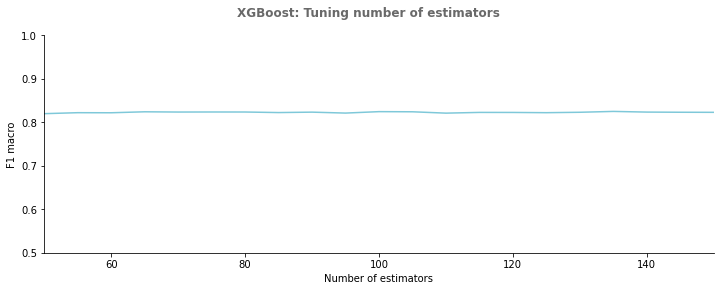

In [136]:
#Visualizing hyperparameter tuning
#Creating plot architecture
fig, ax = plt.subplots(figsize = (12, 4))
sns.despine(top = True)
fig.suptitle("XGBoost: Tuning number of estimators",
             color = "#696969",
             weight = "bold",
             size = 12)

#Plotting
plt.plot([x for x in range(50, 151, 5)], abs(gs.cv_results_["mean_test_score"]), color = "#7ec8d9")
plt.ylabel("F1 macro")
plt.ylim(0.5, 1)
plt.xlabel("Number of estimators")
plt.xlim(50, 150)

plt.show()

In [137]:
#Deriving hyperparameters for XGBoost
rndf_params = [{"gamma": np.linspace(0.0005, 0.005, 10)}]
gs = GridSearchCV(xg.XGBClassifier(booster = "gbtree",
                                   #best_params_booster["booster"],
                                   learning_rate = best_params_learning_rate["learning_rate"],
                                   max_depth = best_params_max_depth["max_depth"],
                                   subsample = best_params_subsample["subsample"], 
                                   colsample_bytree = best_params_colsample["colsample_bytree"], 
                                   n_estimators = best_params_estimators["n_estimators"]), 
                  param_grid = rndf_params,
                  cv = 5, 
                  scoring = "f1_macro")
gs.fit(X_train_lf_vect, y_train_lf["sentiment"])
best_params_gamma = gs.best_params_
best_params_gamma

{'gamma': 0.001}

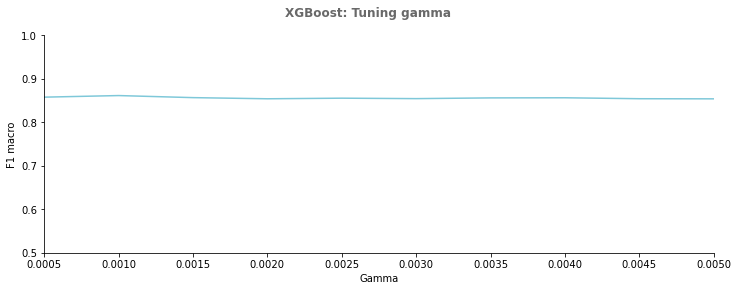

In [138]:
#Visualizing hyperparameter tuning
#Creating plot architecture
fig, ax = plt.subplots(figsize = (12, 4))
sns.despine(top = True)
fig.suptitle("XGBoost: Tuning gamma",
             color = "#696969",
             weight = "bold",
             size = 12)

#Plotting
plt.plot(np.linspace(0.0005, 0.005, 10), abs(gs.cv_results_["mean_test_score"]), color = "#7ec8d9")
plt.ylabel("F1 macro")
plt.ylim(0.5, 1)
plt.xlabel("Gamma")
plt.xlim(0.0005, 0.005)

plt.show()

In [139]:
#Fitting XGBoost
xgbr = xg.XGBClassifier(objective = "binary:f1_macro", 
                        booster = "gbtree",
                        #best_params_booster["booster"],
                        learning_rate = best_params_learning_rate["learning_rate"],
                        max_depth = int(best_params_max_depth["max_depth"]),
                        subsample = best_params_subsample["subsample"],
                        colsample_bytree = best_params_colsample["colsample_bytree"], 
                        n_estimators = best_params_estimators["n_estimators"],
                        gamma = best_params_gamma["gamma"],
                        random_state = 1)
xgbr.fit(X_train_lf_vect, y_train_lf["sentiment"])

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.625,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.001, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=1.2000000000000002, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=18, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=135, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=1,
              reg_alpha=0, ...)

In [140]:
#Evaluating XGBoost
y_test_lf_pred = xgbr.predict(X_test_lf_vect)
print(classification_report(y_test_lf["sentiment"], y_test_lf_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96      1976
         1.0       0.92      0.67      0.78       124
         2.0       0.89      0.77      0.82       340

    accuracy                           0.94      2440
   macro avg       0.92      0.81      0.85      2440
weighted avg       0.94      0.94      0.93      2440



In [141]:
#Saving fitted model
os.chdir("..")
os.chdir("..")
os.chdir("Models/Articles/Snorkel/")
model_name = "xgbr_cv_lf.pkl"
with open(model_name, "wb") as file:
    pickle.dump(xgbr, file)
os.chdir("..")
os.chdir("..")
os.chdir("..")
os.chdir("Notebooks/Articles")

In [142]:
#Setting labelling function with XGBR
@labeling_function()
def xgbr_cv_lf(string):
    #Opening models
    os.chdir("..")
    os.chdir("..")
    os.chdir("Models/Articles/Snorkel/")
    with open("cv_lf.pkl", "rb") as file:
        cv = pickle.load(file)
    with open("xgbr_cv_lf.pkl", "rb") as file:
        model = pickle.load(file)
    os.chdir("..")
    os.chdir("..")
    os.chdir("..")
    os.chdir("Notebooks/Articles")
        
    #CountVectorizer transform
    X = cv.transform(pd.Series(string["clause_ABSA"]))
    
    #Prediction
    score = model.predict(X)

    return score[0]

#### Random forest - Spacy vectors

In [143]:
#Deriving hyperparameters for random forest
rndf_params = [{"max_features": np.linspace(0.5, 1, num = 3)}]
gs = GridSearchCV(RandomForestClassifier(class_weight = {0: 1, 1: 8, 2: 5}), 
                  param_grid = rndf_params,
                  cv = 2, 
                  scoring = "f1_macro")
gs.fit(X_train_lf_embed["clause_ABSA_spacy_vectors"].to_list(), y_train_lf["sentiment"])
best_params_max_features = gs.best_params_
best_params_max_features

{'max_features': 1.0}

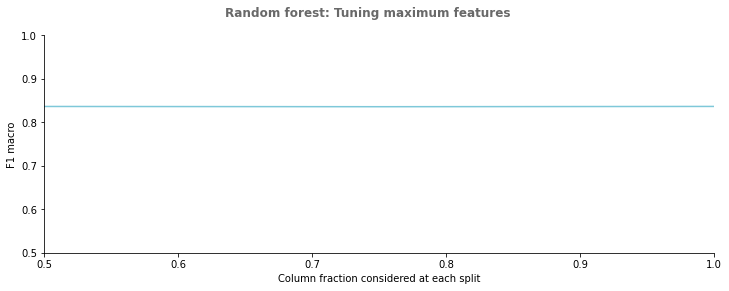

In [144]:
#Visualizing hyperparameter tuning
#Creating plot architecture
fig, ax = plt.subplots(figsize = (12, 4))
sns.despine(top = True)
fig.suptitle("Random forest: Tuning maximum features",
             color = "#696969",
             weight = "bold",
             size = 12)

#Plotting
plt.plot(np.linspace(0.5, 1, num = 3), abs(gs.cv_results_["mean_test_score"]), color = "#7ec8d9")
plt.ylabel("F1 macro")
plt.ylim(0.5, 1)
plt.xlabel("Column fraction considered at each split")
plt.xlim(0.5, 1)

plt.show()

In [145]:
#Deriving hyperparameters for random forest
rndf_params = [{"n_estimators": [x for x in range(25, 51, 5)]}]
gs = GridSearchCV(RandomForestClassifier(class_weight = {0: 1, 1: 8, 2: 5},
                                         max_features = best_params_max_features["max_features"]), 
                  param_grid = rndf_params,
                  cv = 2, 
                  scoring = "f1_macro")
gs.fit(X_train_lf_embed["clause_ABSA_spacy_vectors"].to_list(), y_train_lf["sentiment"])
best_params_estimators = gs.best_params_
best_params_estimators

{'n_estimators': 25}

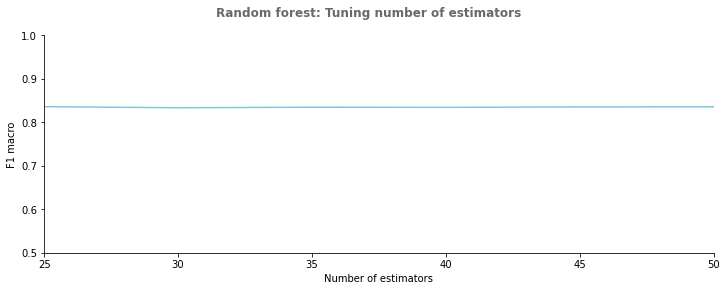

In [146]:
#Visualizing hyperparameter tuning
#Creating plot architecture
fig, ax = plt.subplots(figsize = (12, 4))
sns.despine(top = True)
fig.suptitle("Random forest: Tuning number of estimators",
             color = "#696969",
             weight = "bold",
             size = 12)

#Plotting
plt.plot([x for x in range(25, 51, 5)], abs(gs.cv_results_["mean_test_score"]), color = "#7ec8d9")
plt.ylabel("F1 macro")
plt.ylim(0.5, 1)
plt.xlabel("Number of estimators")
plt.xlim(25, 50)

plt.show()

In [147]:
#Deriving hyperparameters for random forest
rndf_params = [{"max_depth": [26,28,30,32]}]
gs = GridSearchCV(RandomForestClassifier(class_weight = {0: 1, 1: 8, 2: 5},
                                         max_features = best_params_max_features["max_features"], 
                                         n_estimators = best_params_estimators["n_estimators"]), 
                  param_grid = rndf_params,
                  cv = 2, 
                  scoring = "f1_macro")
gs.fit(X_train_lf_embed["clause_ABSA_spacy_vectors"].to_list(), y_train_lf["sentiment"])
best_params_max_depth = gs.best_params_
best_params_max_depth

{'max_depth': 28}

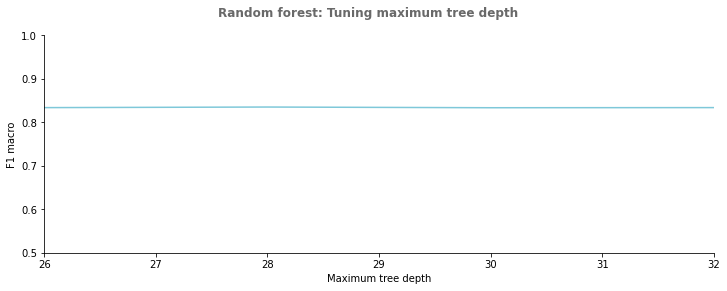

In [148]:
#Visualizing hyperparameter tuning
#Creating plot architecture
fig, ax = plt.subplots(figsize = (12, 4))
sns.despine(top = True)
fig.suptitle("Random forest: Tuning maximum tree depth",
             color = "#696969",
             weight = "bold",
             size = 12)

#Plotting
plt.plot([26,28,30,32], abs(gs.cv_results_["mean_test_score"]), color = "#7ec8d9")
plt.ylabel("F1 macro")
plt.ylim(0.5, 1)
plt.xlabel("Maximum tree depth")
plt.xlim(26, 32)

plt.show()

In [149]:
#Fitting random forest
rf = RandomForestClassifier(class_weight = {0: 1, 1: 8, 2: 5},
                            max_features = best_params_max_features["max_features"], 
                            n_estimators = best_params_estimators["n_estimators"],
                            max_depth = best_params_max_depth["max_depth"],
                            random_state = 1)
rf.fit(X_train_lf_embed["clause_ABSA_spacy_vectors"].to_list(), y_train_lf["sentiment"])

RandomForestClassifier(class_weight={0: 1, 1: 8, 2: 5}, max_depth=28,
                       max_features=1.0, n_estimators=25, random_state=1)

In [150]:
#Evaluating random forest
y_test_lf_pred = rf.predict(X_test_lf_embed["clause_ABSA_spacy_vectors"].to_list())
print(classification_report(y_test_lf["sentiment"], y_test_lf_pred))

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97      1976
         1.0       0.96      0.69      0.80       124
         2.0       0.99      0.73      0.84       340

    accuracy                           0.94      2440
   macro avg       0.96      0.80      0.87      2440
weighted avg       0.95      0.94      0.94      2440



In [151]:
#Saving fitted model
os.chdir("..")
os.chdir("..")
os.chdir("Models/Articles/Snorkel/")
model_name = "rf_spacy_lf.pkl"
with open(model_name, "wb") as file:
    pickle.dump(rf, file)
os.chdir("..")
os.chdir("..")
os.chdir("..")
os.chdir("Notebooks/Articles")

In [152]:
#Setting labelling function with random forest
@labeling_function()
def rf_spacy_lf(string):
    #Opening models
    os.chdir("..")
    os.chdir("..")
    os.chdir("Models/Articles/Snorkel/")
    with open("rf_spacy_lf.pkl", "rb") as file:
        model = pickle.load(file)
    os.chdir("..")
    os.chdir("..")
    os.chdir("..")
    os.chdir("Notebooks/Articles")
        
    #Embed
    X = get_spacy_vectors(string["clause_ABSA"])
    
    #Prediction
    score = model.predict(X)

    return score[0]

#### Random forest - CountVectorizer

In [153]:
#Deriving hyperparameters for random forest
rndf_params = [{"max_features": np.linspace(0.5, 1, num = 5)}]
gs = GridSearchCV(RandomForestClassifier(class_weight = {0: 1, 1: 8, 2: 5}), 
                  param_grid = rndf_params,
                  cv = 2, 
                  scoring = "f1_macro")
gs.fit(X_train_lf_vect, y_train_lf["sentiment"])
best_params_max_features = gs.best_params_
best_params_max_features

{'max_features': 0.625}

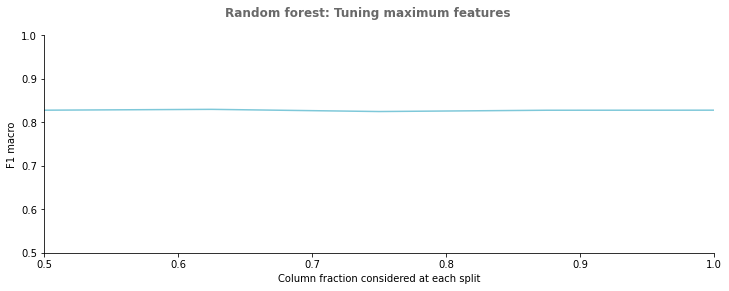

In [154]:
#Visualizing hyperparameter tuning
#Creating plot architecture
fig, ax = plt.subplots(figsize = (12, 4))
sns.despine(top = True)
fig.suptitle("Random forest: Tuning maximum features",
             color = "#696969",
             weight = "bold",
             size = 12)

#Plotting
plt.plot(np.linspace(0.5, 1, num = 5), abs(gs.cv_results_["mean_test_score"]), color = "#7ec8d9")
plt.ylabel("F1 macro")
plt.ylim(0.5, 1)
plt.xlabel("Column fraction considered at each split")
plt.xlim(0.5, 1)

plt.show()

In [155]:
#Deriving hyperparameters for random forest
rndf_params = [{"n_estimators": [x for x in range(25, 51, 5)]}]
gs = GridSearchCV(RandomForestClassifier(class_weight = {0: 1, 1: 8, 2: 5},
                                         max_features = best_params_max_features["max_features"]), 
                  param_grid = rndf_params,
                  cv = 2, 
                  scoring = "f1_macro")
gs.fit(X_train_lf_vect, y_train_lf["sentiment"])
best_params_estimators = gs.best_params_
best_params_estimators

{'n_estimators': 50}

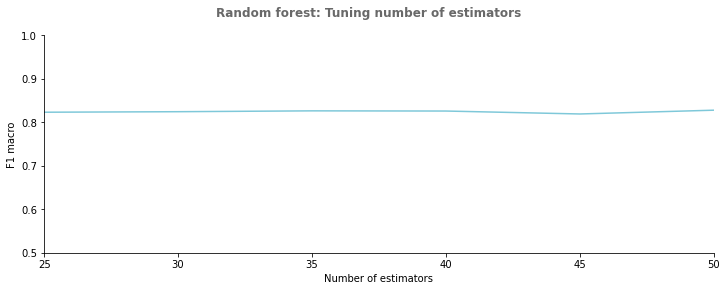

In [156]:
#Visualizing hyperparameter tuning
#Creating plot architecture
fig, ax = plt.subplots(figsize = (12, 4))
sns.despine(top = True)
fig.suptitle("Random forest: Tuning number of estimators",
             color = "#696969",
             weight = "bold",
             size = 12)

#Plotting
plt.plot([x for x in range(25, 51, 5)], abs(gs.cv_results_["mean_test_score"]), color = "#7ec8d9")
plt.ylabel("F1 macro")
plt.ylim(0.5, 1)
plt.xlabel("Number of estimators")
plt.xlim(25, 50)

plt.show()

In [157]:
#Deriving hyperparameters for random forest
rndf_params = [{"max_depth": [26,28,30,32,34,36]}]
gs = GridSearchCV(RandomForestClassifier(class_weight = {0: 1, 1: 8, 2: 5},
                                         max_features = best_params_max_features["max_features"], 
                                         n_estimators = best_params_estimators["n_estimators"]), 
                  param_grid = rndf_params,
                  cv = 2, 
                  scoring = "f1_macro")
gs.fit(X_train_lf_vect, y_train_lf["sentiment"])
best_params_max_depth = gs.best_params_
best_params_max_depth

{'max_depth': 34}

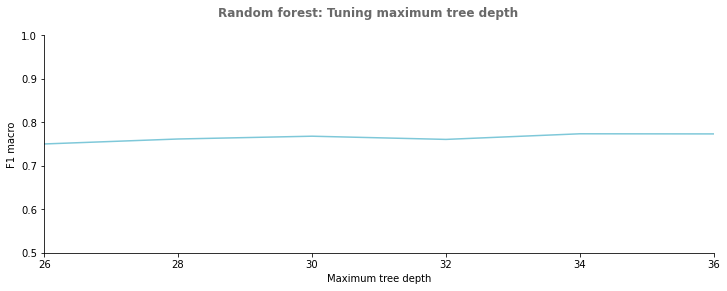

In [158]:
#Visualizing hyperparameter tuning
#Creating plot architecture
fig, ax = plt.subplots(figsize = (12, 4))
sns.despine(top = True)
fig.suptitle("Random forest: Tuning maximum tree depth",
             color = "#696969",
             weight = "bold",
             size = 12)

#Plotting
plt.plot([26,28,30,32,34,36], abs(gs.cv_results_["mean_test_score"]), color = "#7ec8d9")
plt.ylabel("F1 macro")
plt.ylim(0.5, 1)
plt.xlabel("Maximum tree depth")
plt.xlim(26, 36)

plt.show()

In [159]:
#Fitting random forest
rf = RandomForestClassifier(class_weight = {0: 1, 1: 8, 2: 5},
                            max_features = best_params_max_features["max_features"], 
                            n_estimators = best_params_estimators["n_estimators"],
                            max_depth = best_params_max_depth["max_depth"],
                            random_state = 1)
rf.fit(X_train_lf_vect, y_train_lf["sentiment"])

RandomForestClassifier(class_weight={0: 1, 1: 8, 2: 5}, max_depth=34,
                       max_features=0.625, n_estimators=50, random_state=1)

In [160]:
#Evaluating random forest
y_test_lf_pred = rf.predict(X_test_lf_vect)
print(classification_report(y_test_lf["sentiment"], y_test_lf_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95      1976
         1.0       0.96      0.63      0.76       124
         2.0       0.88      0.64      0.74       340

    accuracy                           0.92      2440
   macro avg       0.92      0.75      0.82      2440
weighted avg       0.92      0.92      0.91      2440



In [161]:
#Saving fitted model
os.chdir("..")
os.chdir("..")
os.chdir("Models/Articles/Snorkel/")
model_name = "rf_cv_lf.pkl"
with open(model_name, "wb") as file:
    pickle.dump(rf, file)
os.chdir("..")
os.chdir("..")
os.chdir("..")
os.chdir("Notebooks/Articles")

In [162]:
#Setting labelling function with random forest
@labeling_function()
def rf_cv_lf(string):
    #Opening models
    os.chdir("..")
    os.chdir("..")
    os.chdir("Models/Articles/Snorkel/")
    with open("cv_lf.pkl", "rb") as file:
        cv = pickle.load(file)
    with open("rf_cv_lf.pkl", "rb") as file:
        model = pickle.load(file)
    os.chdir("..")
    os.chdir("..")
    os.chdir("..")
    os.chdir("Notebooks/Articles")
        
    #CountVectorizer transform
    X = cv.transform(pd.Series(string["clause_ABSA"]))
    
    #Prediction
    score = model.predict(X)

    return score[0]

### Section 2.4: <a class="anchor" id="section_2_4"></a> Deep-learning-based LFs

In [163]:
#Setting sentiment map
sentiment_map_guhr = {"positive": 1, "negative": 2, "neutral": 0}

In [164]:
#Defining class for Guhr model
#huggingface.co/oliverguhr/german-sentiment-bert
class SentimentModel_guhr():
    def __init__(self, model_name: str = "oliverguhr/german-sentiment-bert"):
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.clean_chars = re.compile(r'[^A-Za-züöäÖÜÄß ]', re.MULTILINE)

    def predict_sentiment(self, texts: List[str])-> List[str]:
        texts = [self.clean_text(text) for text in texts]
        encoded = self.tokenizer.batch_encode_plus(texts,
                                                   padding = True, 
                                                   add_special_tokens = True,
                                                   truncation = True, 
                                                   return_tensors = "pt")
        #encoded = encoded.to(self.device)
        with torch.no_grad():
                logits = self.model(**encoded)
        label_ids = torch.argmax(logits[0], axis = 1)
        sentiment_list = [self.model.config.id2label[label_id.item()] for label_id in label_ids]
        sentiment_mapped_list = [sentiment_map_guhr[sentiment] for sentiment in sentiment_list]
        return sentiment_mapped_list

    def clean_text(self, text: str)-> str:    
            text = self.clean_chars.sub("", text)                          
            text = " ".join(text.split())
            text = text.strip().lower()
            return text

model_guhr = SentimentModel_guhr(model_name = "oliverguhr/german-sentiment-bert")

In [165]:
#Setting labelling function with Oliver Guhr model
@labeling_function()
def bert_guhr_lf(string):
    #Selecting column
    string = string["clause_ABSA"]
    
    #Transforming string to list format
    string_list = list(string)
    
    #Prediction
    score = model_guhr.predict_sentiment(string_list)

    return score[0]

In [166]:
#Defining class for mdraw model
#https://huggingface.co/mdraw/german-news-sentiment-bert
class SentimentModel_mdraw:
    def __init__(self, model_name: str = "oliverguhr/german-sentiment-bert"):
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name)
        self.tokenizer = AutoTokenizer.from_pretrained("oliverguhr/german-sentiment-bert")
        self.clean_chars = re.compile(r'[^A-Za-züöäÖÜÄß ]', re.MULTILINE)

    def clean_text(self, text: str) -> str:
        text = self.clean_chars.sub("", text)
        text = " ".join(text.split())
        text = text.strip().lower()
        return text

    @staticmethod
    def probs2polarities(pnn: torch.Tensor) -> torch.Tensor:
        """Transform softmax probs of a [positive, negative, neutral] classifier
        into scalar polarity scores of range [-1, 1]."""
        pos = pnn[:, 0]
        neg = pnn[:, 1]
        polarities = pos - neg
        return polarities

    def predict_sentiment_batch(self, texts: List[str]) -> torch.Tensor:
        texts = [self.clean_text(text) for text in texts]
        input_ids = self.tokenizer.batch_encode_plus(texts,
                                                     padding = True,
                                                     add_special_tokens = True,
                                                     truncation = True)
        input_ids = torch.tensor(input_ids["input_ids"])

        with torch.no_grad():
            logits = self.model(input_ids)
            probs = F.softmax(logits[0], dim = 1)

        polarity_scores = self.probs2polarities(probs)
        
        return polarity_scores

    def analyse_sentiment(self, text: str) -> float:
        polarity_score = self.predict_sentiment_batch([text]).item()
        if polarity_score > 0.5:
            polarity = 1
        elif polarity_score < -0.5:
            polarity = 2
        else:
            polarity = 0
        return polarity

model_mdraw = SentimentModel_mdraw("mdraw/german-news-sentiment-bert")    

In [167]:
#Setting labelling function with mdraw model
@labeling_function()
def bert_mdraw_lf(string):
    #Selecting column
    string = string["clause_ABSA"]
    
    #Prediction
    score = model_mdraw.analyse_sentiment(string)

    return score

### Section 2.5: <a class="anchor" id="section_2_5"></a> Evaluating LFs

In [168]:
#Defining function to generate prediction with care around positive statements
def make_custom_prediction(y_pred):
    df_pred = pd.DataFrame(data = y_pred, 
                           columns = ["textblob", 
                                      "sentiws", 
                                      "polart", 
                                      "gervader", 
                                      "claim",
                                      "log_reg_cv_lf", 
                                      "svm_cv_lf", 
                                      "xgbr_cv_lf", 
                                      "rf_cv_lf",
                                      "xgbr_spacy_lf", 
                                      "rf_spacy_lf",
                                      "bert_mdraw_lf"])
    
    label_model.fit(L_train = y_pred)
    y_est = label_model.predict(L = y_pred, return_probs = True)
    df_pred["final_pred"] = pd.Series(y_est[0])
    
    def neutralize_pos(value_list, original_prediction):
        if original_prediction == 1.0:
            if value_list.count(1.0) < 3:
                return 0.0
            else:
                return 1.0
        else:
            return float(original_prediction)
    
    df_pred["final_pred"] = df_pred.apply(lambda x: neutralize_pos(list(x["textblob":"bert_mdraw_lf"]), x["final_pred"]), 
                                          axis = 1)
    
    return df_pred["final_pred"]

In [169]:
#Applying labelling functions with empirical accuracy > 0.5
lfs = [textblob, 
       sentiws, 
       polart, 
       gervader, 
       #emotion, 
       #modal, 
       #conjunctive, 
       #reproach, 
       claim,
       #positive,
       log_reg_cv_lf, 
       svm_cv_lf, 
       xgbr_cv_lf, 
       rf_cv_lf,
       #log_reg_spacy_lf, 
       #svm_spacy_lf, 
       xgbr_spacy_lf, 
       rf_spacy_lf, 
       #bert_guhr_lf,
       bert_mdraw_lf]
applier = PandasLFApplier(lfs = lfs)
y_test_lf_pred = applier.apply(df = X_test_lf)

100%|███████████████████████████████████████| 2440/2440 [13:42<00:00,  2.97it/s]


In [170]:
#Getting overview of labelling functions
LFAnalysis(y_test_lf_pred, lfs).lf_summary(np.array(y_test_lf["sentiment"]))

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
textblob,0,"[0, 1, 2]",1.000000,1.000000,0.729918,1605,835,0.657787
sentiws,1,"[0, 1, 2]",1.000000,1.000000,0.729918,1703,737,0.697951
polart,2,"[0, 1, 2]",1.000000,1.000000,0.729918,1450,990,0.594262
gervader,3,"[0, 1, 2]",1.000000,1.000000,0.729918,1531,909,0.627459
claim,4,[0],0.121311,0.121311,0.086066,262,34,0.885135
log_reg_cv_lf,5,"[0, 1, 2]",1.000000,1.000000,0.729918,2289,151,0.938115
svm_cv_lf,6,"[0, 1, 2]",1.000000,1.000000,0.729918,2309,131,0.946311
xgbr_cv_lf,7,"[0, 1, 2]",1.000000,1.000000,0.729918,2285,155,0.936475
rf_cv_lf,8,"[0, 1, 2]",1.000000,1.000000,0.729918,2244,196,0.919672
xgbr_spacy_lf,9,"[0, 1, 2]",1.000000,1.000000,0.729918,1680,760,0.688525


In [171]:
#Generating predictions via LabelModel
label_model = LabelModel(cardinality = 3, verbose = True)
label_model.fit(L_train = y_test_lf_pred)
y_test_lf_est = label_model.predict(L = y_test_lf_pred, return_probs = True)
y_test_lf_est = pd.Series(y_test_lf_est)

INFO:root:Computing O...
INFO:root:Estimating \mu...
  0%|                                                | 0/100 [00:00<?, ?epoch/s]INFO:root:[0 epochs]: TRAIN:[loss=37.532]
INFO:root:[10 epochs]: TRAIN:[loss=5.544]
INFO:root:[20 epochs]: TRAIN:[loss=1.452]
INFO:root:[30 epochs]: TRAIN:[loss=1.883]
INFO:root:[40 epochs]: TRAIN:[loss=0.336]
INFO:root:[50 epochs]: TRAIN:[loss=0.421]
INFO:root:[60 epochs]: TRAIN:[loss=0.178]
INFO:root:[70 epochs]: TRAIN:[loss=0.178]
INFO:root:[80 epochs]: TRAIN:[loss=0.140]
INFO:root:[90 epochs]: TRAIN:[loss=0.133]
100%|████████████████████████████████████| 100/100 [00:00<00:00, 1906.07epoch/s]
INFO:root:Finished Training


In [172]:
#Evaluating labelling functions
print(classification_report(y_test_lf["sentiment"], y_test_lf_est[0]))

              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95      1976
         1.0       0.46      0.32      0.38       124
         2.0       0.70      0.81      0.75       340

    accuracy                           0.90      2440
   macro avg       0.71      0.69      0.69      2440
weighted avg       0.89      0.90      0.89      2440



In [173]:
#Generating predictions via custom prediction
label_model = LabelModel(cardinality = 3, verbose = True)
y_test_lf_est = make_custom_prediction(y_test_lf_pred)

INFO:root:Computing O...
INFO:root:Estimating \mu...
  0%|                                                | 0/100 [00:00<?, ?epoch/s]INFO:root:[0 epochs]: TRAIN:[loss=37.532]
INFO:root:[10 epochs]: TRAIN:[loss=5.544]
INFO:root:[20 epochs]: TRAIN:[loss=1.452]
INFO:root:[30 epochs]: TRAIN:[loss=1.883]
INFO:root:[40 epochs]: TRAIN:[loss=0.336]
INFO:root:[50 epochs]: TRAIN:[loss=0.421]
INFO:root:[60 epochs]: TRAIN:[loss=0.178]
INFO:root:[70 epochs]: TRAIN:[loss=0.178]
INFO:root:[80 epochs]: TRAIN:[loss=0.140]
INFO:root:[90 epochs]: TRAIN:[loss=0.133]
100%|████████████████████████████████████| 100/100 [00:00<00:00, 1334.31epoch/s]
INFO:root:Finished Training


In [174]:
#Evaluating labelling functions
print(classification_report(y_test_lf["sentiment"], y_test_lf_est))

              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95      1976
         1.0       0.49      0.31      0.38       124
         2.0       0.70      0.81      0.75       340

    accuracy                           0.90      2440
   macro avg       0.71      0.69      0.70      2440
weighted avg       0.89      0.90      0.89      2440



## Chapter 3: <a class="anchor" id="chapter3"></a> Propagation

In [175]:
#Defining function to propagate labels
def propagate_label_model(X):
    y_non_lf_pred = applier.apply(df = X)
    label_model.fit(L_train = y_non_lf_pred)
    y_non_lf_est = label_model.predict(L = y_non_lf_pred)
    y_non_lf_est = pd.Series(y_non_lf_est)
    return y_non_lf_est

In [176]:
#Defining function to propagate labels
def propagate_custom_prediction(X):
    y_non_lf_pred = applier.apply(df = X)
    y_non_lf_est = make_custom_prediction(y_non_lf_pred)
    return y_non_lf_est

In [177]:
#Defining function to integrate estimated labels into existing dataframes
def integrate_est_labels(y_est, y):
    y["sentiment"] = y_est.values
    y["manual_annotation"] = 0
    return y

In [178]:
#Instantiating LabelModel
label_model = LabelModel(cardinality = 3, verbose = True)

In [179]:
#Propagating labels
y_test_non_lf_est = propagate_custom_prediction(X_test_non_lf)
y_test_non_lf_est.value_counts(normalize = True)

100%|███████████████████████████████████| 40996/40996 [3:27:43<00:00,  3.29it/s]
INFO:root:Computing O...
INFO:root:Estimating \mu...
  0%|                                                | 0/100 [00:00<?, ?epoch/s]INFO:root:[0 epochs]: TRAIN:[loss=43.214]
INFO:root:[10 epochs]: TRAIN:[loss=4.451]
INFO:root:[20 epochs]: TRAIN:[loss=2.624]
INFO:root:[30 epochs]: TRAIN:[loss=1.458]
INFO:root:[40 epochs]: TRAIN:[loss=0.519]
INFO:root:[50 epochs]: TRAIN:[loss=0.276]
INFO:root:[60 epochs]: TRAIN:[loss=0.143]
INFO:root:[70 epochs]: TRAIN:[loss=0.105]
INFO:root:[80 epochs]: TRAIN:[loss=0.076]
INFO:root:[90 epochs]: TRAIN:[loss=0.063]
100%|████████████████████████████████████| 100/100 [00:00<00:00, 1909.26epoch/s]
INFO:root:Finished Training


0.0    0.863816
2.0    0.101229
1.0    0.034955
Name: final_pred, dtype: float64

In [180]:
#Propagating labels
y_vali_non_lf_est = propagate_custom_prediction(X_vali_non_lf)
y_vali_non_lf_est.value_counts(normalize = True)

100%|███████████████████████████████████| 32797/32797 [2:47:25<00:00,  3.27it/s]
INFO:root:Computing O...
INFO:root:Estimating \mu...
  0%|                                                | 0/100 [00:00<?, ?epoch/s]INFO:root:[0 epochs]: TRAIN:[loss=43.134]
INFO:root:[10 epochs]: TRAIN:[loss=4.475]
INFO:root:[20 epochs]: TRAIN:[loss=2.593]
INFO:root:[30 epochs]: TRAIN:[loss=1.466]
INFO:root:[40 epochs]: TRAIN:[loss=0.512]
INFO:root:[50 epochs]: TRAIN:[loss=0.277]
INFO:root:[60 epochs]: TRAIN:[loss=0.141]
INFO:root:[70 epochs]: TRAIN:[loss=0.104]
INFO:root:[80 epochs]: TRAIN:[loss=0.075]
INFO:root:[90 epochs]: TRAIN:[loss=0.062]
100%|████████████████████████████████████| 100/100 [00:00<00:00, 1839.95epoch/s]
INFO:root:Finished Training


0.0    0.861634
2.0    0.104217
1.0    0.034149
Name: final_pred, dtype: float64

In [181]:
#Propagating labels
y_train_non_lf_est = propagate_custom_prediction(X_train_non_lf)
y_train_non_lf_est.value_counts(normalize = True)

100%|████████████████████████████████| 131186/131186 [11:04:08<00:00,  3.29it/s]
INFO:root:Computing O...
INFO:root:Estimating \mu...
  0%|                                                | 0/100 [00:00<?, ?epoch/s]INFO:root:[0 epochs]: TRAIN:[loss=43.225]
INFO:root:[10 epochs]: TRAIN:[loss=4.458]
INFO:root:[20 epochs]: TRAIN:[loss=2.622]
INFO:root:[30 epochs]: TRAIN:[loss=1.459]
INFO:root:[40 epochs]: TRAIN:[loss=0.519]
INFO:root:[50 epochs]: TRAIN:[loss=0.276]
INFO:root:[60 epochs]: TRAIN:[loss=0.143]
INFO:root:[70 epochs]: TRAIN:[loss=0.105]
INFO:root:[80 epochs]: TRAIN:[loss=0.076]
INFO:root:[90 epochs]: TRAIN:[loss=0.062]
100%|████████████████████████████████████| 100/100 [00:00<00:00, 1426.05epoch/s]
INFO:root:Finished Training


0.0    0.863088
2.0    0.102419
1.0    0.034493
Name: final_pred, dtype: float64

In [182]:
#Integrating labels
y_test_non_lf = integrate_est_labels(y_test_non_lf_est, y_test_non_lf)

In [183]:
#Integrating labels
y_vali_non_lf = integrate_est_labels(y_vali_non_lf_est, y_vali_non_lf)

In [184]:
#Integrating labels
y_train_non_lf = integrate_est_labels(y_train_non_lf_est, y_train_non_lf)

In [185]:
#Saving to CSV
os.chdir("..")
os.chdir("..")
dfs = [X_train_lf, y_train_lf, X_vali_lf, y_vali_lf, X_test_lf, y_test_lf, X_train_non_lf, y_train_non_lf, X_vali_non_lf, y_vali_non_lf, X_test_non_lf, y_test_non_lf]
for subdf in dfs:
    subdf.to_csv(f"Outputs/Articles/Snorkel/{retrieve_name(subdf)}.csv")
    time.sleep(5)
os.chdir("Notebooks/Articles")

In [187]:
#Merging data
X = pd.concat([X_train_lf, X_vali_lf, X_test_lf, X_train_non_lf, X_vali_non_lf, X_test_non_lf])
y = pd.concat([y_train_lf, y_vali_lf, y_test_lf, y_train_non_lf, y_vali_non_lf, y_test_non_lf])
y["sentiment"] = y["sentiment"].astype("float")
y["manual_annotation"] = y["manual_annotation"].astype("float")
df_snorkel = X.join(y)

In [188]:
#Resetting index
df_snorkel = df_snorkel.reset_index()

In [189]:
#Sorting values
df_snorkel = df_snorkel.sort_values(by = "pubtime").reset_index(drop = True)

In [190]:
#Re-mapping sentiment to [-1,1] spectrum
sentiment_map = {"0.0": 0, "1.0": 1, "2.0": -1}
df_snorkel["sentiment"] = df_snorkel["sentiment"].apply(lambda x: sentiment_map[str(x)])

In [192]:
#Saving to CSV
os.chdir("..")
os.chdir("..")
df_snorkel.to_csv("Outputs/Articles/Snorkel/snorkel.csv")
os.chdir("Notebooks/Articles")